# Imports

In [1]:
import pandas as pd
import numpy as np

import re
import regex
import string
import torch

import gzip
import os

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from textblob import TextBlob

from collections import Counter
from wordcloud import WordCloud


from langdetect import detect
from tqdm import tqdm
import emoji
import contractions
import spacy

from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, BertTokenizer, BertModel, XLMRobertaTokenizer, XLMRobertaModel

import gensim
from gensim.models import fasttext
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_vectors, load_facebook_model

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import xgboost as xgb

from keras.layers import Input, Dense, concatenate
from keras.models import Model
import tensorflow as tf
from keras.callbacks import EarlyStopping



# Load the data

In [2]:
train_df = pd.read_excel('train.xlsx')
train_reviews_df = pd.read_excel('train_reviews.xlsx')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        6248 non-null   int64 
 1   description  6248 non-null   object
 2   host_about   6248 non-null   object
 3   unlisted     6248 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.4+ KB


# Split the data

In [3]:
X = train_df
X_reviews = train_reviews_df

X_train, X_test = train_test_split(X, test_size=0.15, random_state=42)

In [4]:
X_train_reviews = X_reviews[X_reviews['index'].isin(X_train['index'])]
X_test_reviews = X_reviews[~X_reviews['index'].isin(X_train['index'])]

In [5]:
X_train.head(3)

,index,description,host_about,unlisted
6060,6061,Charming apartment inside a luxury condominium...,I’m from Lisbon and I Like to travel around th...,1
4076,4077,Amazing modern one bedroom apartment near Merc...,We are Feels Like Home Holiday Rentals.\nA com...,0
1039,1040,NOVO! O Tropical Pool View - Checkinhome é um ...,Olá! Chamo-me Cláudia Diniz e sou responsável ...,1


In [6]:
X_train_reviews.head(3)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."


# EXPLORATION

In [7]:
X_train.describe()

,index,unlisted
count,5310.000000,5310.000000
mean,3133.532392,0.274011
std,1803.853759,0.446057
min,1.000000,0.000000
25%,1574.250000,0.000000
50%,3134.500000,0.000000
75%,4703.750000,1.000000
max,6248.000000,1.000000


In [8]:
X_train_reviews.describe()

,index
count,308687.000000
mean,3076.706291
std,1804.291714
min,1.000000
25%,1487.000000
50%,3028.000000
75%,4629.000000
max,6248.000000


In [9]:
X_train.isna().sum() 

index          0
description    0
host_about     0
unlisted       0
dtype: int64

In [10]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

In [11]:
X_train_reviews.isna().sum() 

index       0
comments    2
dtype: int64

In [12]:
X_train_reviews.dropna(inplace=True)
X_test_reviews.dropna(inplace=True)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_15148\859366503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reviews.dropna(inplace=True)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_15148\859366503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reviews.dropna(inplace=True)


In [13]:
X_train.duplicated().sum()

0

In [14]:
X_train_reviews.duplicated().sum()

126

In [15]:
X_train_reviews.drop_duplicates(inplace=True)
X_test_reviews.drop_duplicates(inplace=True)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_15148\3826442046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reviews.drop_duplicates(inplace=True)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_15148\3826442046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reviews.drop_duplicates(inplace=True)


## Word Count

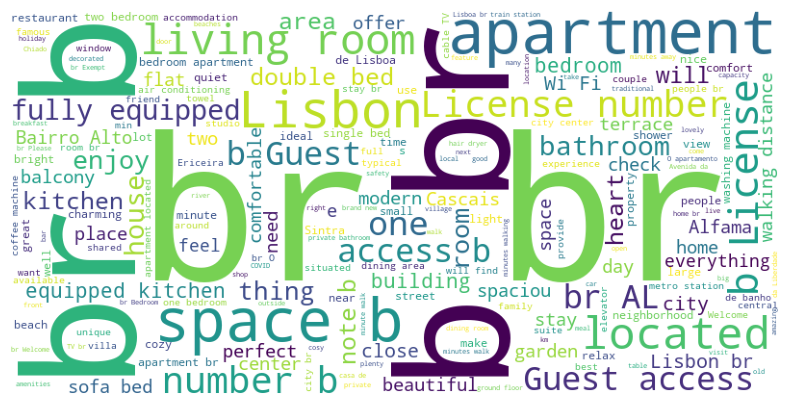

In [16]:
all_descriptions = ' '.join(X_train['description'])
    
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_descriptions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

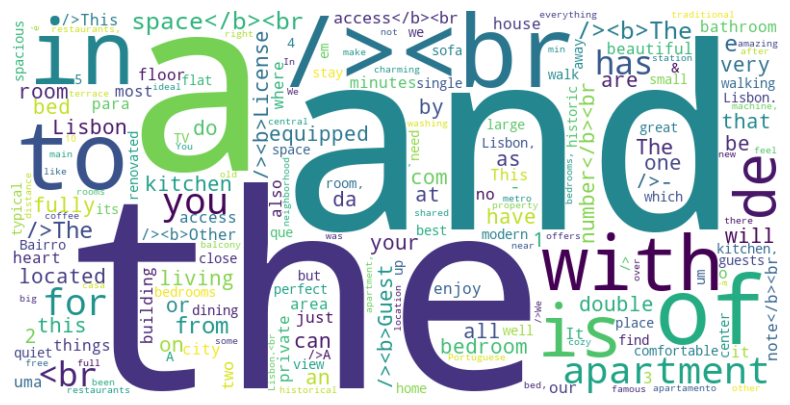

In [17]:
text = ' '.join(X_train['description'].dropna())

words = text.split()
word_freq = Counter(words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Visualisations

unlisted
0    3855
1    1455
Name: count, dtype: int64


<Axes: xlabel='unlisted'>

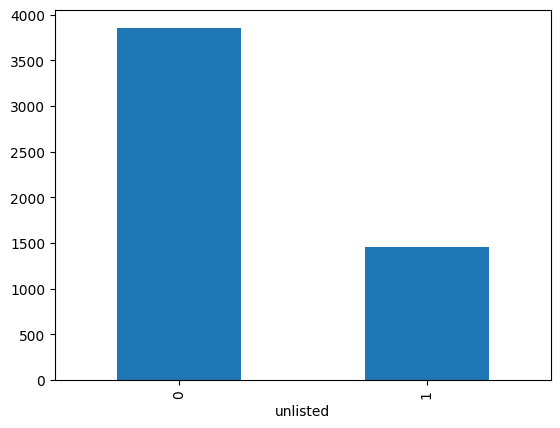

In [18]:
print(X_train['unlisted'].value_counts())
X_train['unlisted'].value_counts().plot(kind='bar')

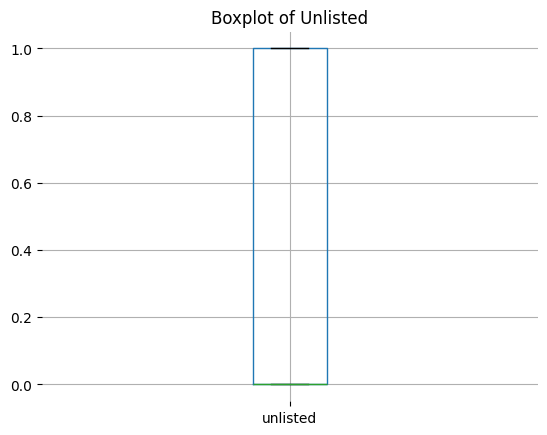

In [19]:
X_train.boxplot(column=['unlisted'])
plt.title('Boxplot of Unlisted')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

## X_Train

### Description

In [20]:
exploration = X_train[X_train["description"].str.contains("<b", na=False)].head(2)
exploration

,index,description,host_about,unlisted
6060,6061,Charming apartment inside a luxury condominium...,I’m from Lisbon and I Like to travel around th...,1
4076,4077,Amazing modern one bedroom apartment near Merc...,We are Feels Like Home Holiday Rentals.\nA com...,0


In [21]:
exploration.loc[:20, 'description'].str[-70:]

6060    .<br />The apartment also offers one full and ...
4076    nal price (2€/person/day). If it has not been ...
Name: description, dtype: object

In [22]:
X_train['word_count']  = X_train['description'].apply(lambda x: len(str(x).split(" ")))
X_train[['description','word_count']].head()

,description,word_count
6060,Charming apartment inside a luxury condominium...,157
4076,Amazing modern one bedroom apartment near Merc...,160
1039,NOVO! O Tropical Pool View - Checkinhome é um ...,159
2118,Located on the second floor of one the new ico...,121
5738,A casa está situada no limite da cidade de Lis...,176


In [23]:
X_train.word_count.describe()

count    5310.000000
mean      132.555744
std        48.126992
min         3.000000
25%        99.000000
50%       157.000000
75%       167.000000
max       210.000000
Name: word_count, dtype: float64

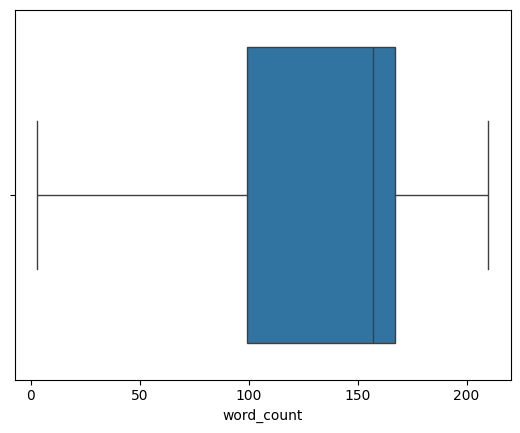

In [24]:
# plot boxplot to look for outliars
sns.boxplot(x = X_train["word_count"])
plt.show()

In [25]:
X_train[X_train["word_count"] <= 3]["description"]

2187     <b>License number</b><br />36053/AL
5869     <b>License number</b><br />60911/AL
5769     <b>License number</b><br />45360/AL
1235    <b>License number</b><br />121745/AL
2500       <b>License number</b><br />Exempt
                        ...                 
3255      <b>License number</b><br />3131/AL
2999    <b>License number</b><br />105154/AL
5739     <b>License number</b><br />36810/AL
4514     <b>License number</b><br />41664/AL
3461     <b>License number</b><br />71805/AL
Name: description, Length: 77, dtype: object

In [26]:
X_train[X_train["word_count"] <= 10]["description"].count()

109

### Patterns:

In [27]:
text = X_train["description"].iloc[66]
print(text)

Welcome to our apartment!<br />We believe this beautiful apartment will be a plus in your Lisbon experience. With 1 bedroom, a well equipped kitchen and a pleasant living room with a sofa bed, you will be between Alcantara and the lively district of Santos, served by great transport links and a great place to stay in and enjoy Lisbon.<br />We hope you enjoy your stay!<br /><br /><b>The space</b><br />A beautiful brand new one bedroom apartment that serves as a perfect base for visiting Lisbon.<br />The living area is light and airy with a beautiful, modern design and lovely finishing touches. It’s a welcoming and inviting space where you can kick back.<br />The master bedroom has a super comfortable queen bed and, with fresh sheets, what more do you need for a good night’s sleep? You'll have a double sofa bed in the living room, where two people can sleep.<br />Our property will be professionally cleaned before your stay.<br /><br /><b>Guest access</b><br />You will have the whole plac

In [28]:
pattern = r'License number.*$'
new_text = re.sub(pattern, '', text)
print(new_text)

Welcome to our apartment!<br />We believe this beautiful apartment will be a plus in your Lisbon experience. With 1 bedroom, a well equipped kitchen and a pleasant living room with a sofa bed, you will be between Alcantara and the lively district of Santos, served by great transport links and a great place to stay in and enjoy Lisbon.<br />We hope you enjoy your stay!<br /><br /><b>The space</b><br />A beautiful brand new one bedroom apartment that serves as a perfect base for visiting Lisbon.<br />The living area is light and airy with a beautiful, modern design and lovely finishing touches. It’s a welcoming and inviting space where you can kick back.<br />The master bedroom has a super comfortable queen bed and, with fresh sheets, what more do you need for a good night’s sleep? You'll have a double sofa bed in the living room, where two people can sleep.<br />Our property will be professionally cleaned before your stay.<br /><br /><b>Guest access</b><br />You will have the whole plac

In [29]:
#excel
pattern = r'_[xX]000[dD]_'
X_train[X_train['description'].str.contains(pattern, regex=True)]

,index,description,host_about,unlisted,word_count


In [30]:
#html
pattern = r'<[a-zA-Z/][^>]*>?'
X_train[X_train['description'].str.contains(pattern, regex=True)]

,index,description,host_about,unlisted,word_count
6060,6061,Charming apartment inside a luxury condominium...,I’m from Lisbon and I Like to travel around th...,1,157
4076,4077,Amazing modern one bedroom apartment near Merc...,We are Feels Like Home Holiday Rentals.\nA com...,0,160
1039,1040,NOVO! O Tropical Pool View - Checkinhome é um ...,Olá! Chamo-me Cláudia Diniz e sou responsável ...,1,159
2118,2119,Located on the second floor of one the new ico...,"Innkeeper is a property management company, th...",0,121
5738,5739,A casa está situada no limite da cidade de Lis...,Tenho 40 anos e gosto de viajar e conhecer nov...,1,176
...,...,...,...,...,...
3772,3773,Caxias is one of the most tranquile neighborho...,"I love sports and adventures, I love to be wit...",0,88
5191,5192,"Here it is perfect to learn to surf, but there...",we are the union of surfing and yoga. Surfer o...,1,92
5226,5227,Sua família vai estar perto de tudo ao ficar n...,Sou Damaris,0,97
5390,5391,Discover an inviting space filled with light a...,"My husband Ian and I love different cultures, ...",0,39


In [31]:
#License Number
pattern = r'license number.*$'
X_train[X_train['description'].str.contains(pattern, regex=True)]

,index,description,host_about,unlisted,word_count


In [32]:
pattern = r'<[a-zA-Z/][^>]*>?' #HTLM
print(re.sub(pattern, '', new_text))

Welcome to our apartment!We believe this beautiful apartment will be a plus in your Lisbon experience. With 1 bedroom, a well equipped kitchen and a pleasant living room with a sofa bed, you will be between Alcantara and the lively district of Santos, served by great transport links and a great place to stay in and enjoy Lisbon.We hope you enjoy your stay!The spaceA beautiful brand new one bedroom apartment that serves as a perfect base for visiting Lisbon.The living area is light and airy with a beautiful, modern design and lovely finishing touches. It’s a welcoming and inviting space where you can kick back.The master bedroom has a super comfortable queen bed and, with fresh sheets, what more do you need for a good night’s sleep? You'll have a double sofa bed in the living room, where two people can sleep.Our property will be professionally cleaned before your stay.Guest accessYou will have the whole plac


In [33]:
# Currency symbols

def find_currency(text):
    pattern =  r'(\p{Sc}\s*[0-9]{1,3}(?:,[0-9]{3})*(?:\.[0-9]+)?)|([0-9]{1,3}(?:,[0-9]{3})*(?:\.[0-9]+)?\s*\p{Sc})'
    return regex.findall(pattern, str(text))

X_train['currency_symbols'] = X_train['description'].apply(find_currency)
filtered_df = X_train[X_train['currency_symbols'].apply(lambda x: len(x) > 0)]

filtered_df[['index','description', 'currency_symbols']].head(3)

,index,description,currency_symbols
4076,4077,Amazing modern one bedroom apartment near Merc...,"[(, 2€)]"
3053,3054,"Located in the lovely Bairro Alto area, makes ...","[(, 150€)]"
1886,1887,"We are located in the old-town, near Alfama, C...","[(, 2€), (, 3€)]"


In [34]:
text = X_train[X_train['index']==4077]["description"].iloc[0]
print(text)

Amazing modern one bedroom apartment near Mercado da Ribeira in Lisbon's downtown!<br /><br /><b>The space</b><br />Welcome to Feels Like Home Cais Sodré Charming Flat!<br /><br />This fantastic apartment has one bedroom with a double bed, one bathroom with shower, and a bright living room with a fully equipped kitchenette, dining area and a sofa-bed for two.<br /><br />Nº 98833/AL<br /><br /><b>Other things to note</b><br />A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br />Guests must pick-up the keys at the Welcome Centre located in Lisbon. Arrivals from 23:00 (11pm) to 06:00 (06am), a late check-in fee of EUR 30 shall be applied (paid in cash at check-in).<br />All guests must provide their ID or Passport Information at the time of check-in.<br />Please note that a mandatory touristic tax will be included in the final price (2€/person/day). If it has not been charged at the moment of

In [35]:
#usernames
pattern = r'@\b[a-zA-Z0-9._]{3,15}\b'
X_train[X_train['description'].str.contains(pattern, regex=True)].head(2)

,index,description,host_about,unlisted,word_count,currency_symbols
180,181,"Right in the center of Lisbon, a few minutes f...","We are BmyGuest, a Short Term Rental company t...",0,160,[]
1089,1090,Apartamento com Ar Condicionado junto ao Jardi...,We love Lisbon and to know people of the world...,0,158,[]


In [36]:
#emails
pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
X_train[X_train['description'].str.contains(pattern, regex=True)].head(2)

,index,description,host_about,unlisted,word_count,currency_symbols


In [37]:
#dates
pattern =  r'\b(?:\d{1,2}[-/]\d{1,2}[-/](?:\d{2}|\d{4})|\d{4}[-/]\d{1,2}[-/]\d{1,2})\b'
X_train[X_train['description'].str.contains(pattern, regex=True)].head(2)

,index,description,host_about,unlisted,word_count,currency_symbols
4884,4885,Apartamento muito bem localizado .Em condomini...,"Adoro praia, mar,sol o meu filho e o meu marido",0,151,[]
4074,4075,"A small secret of Lisbon: a green, safe area w...",We hope we'll provide you a stay as nice and a...,0,161,[]


In [38]:
#numerical values
pattern =  r'\b\w*[a-zA-Z]+\d+\w*|\w*\d+[a-zA-Z]+\w*\b'
X_train[X_train['description'].str.contains(pattern, regex=True)].head(2)

,index,description,host_about,unlisted,word_count,currency_symbols
4076,4077,Amazing modern one bedroom apartment near Merc...,We are Feels Like Home Holiday Rentals.\nA com...,0,160,"[(, 2€)]"
1039,1040,NOVO! O Tropical Pool View - Checkinhome é um ...,Olá! Chamo-me Cláudia Diniz e sou responsável ...,1,159,[]


In [39]:
X_train.drop(columns = ["word_count", "currency_symbols"], inplace = True)

### Host_About

In [40]:
exploration = X_train[X_train["host_about"].str.contains("<b", na=False)]
exploration

,index,description,host_about,unlisted
820,821,Comfort ensuite room with double bed for 2 per...,"<a href="" (Website hidden by Airbnb) rel=""nofo...",0
5330,5331,Baixa Guest House is close to all the touristi...,"<a href="" (Website hidden by Airbnb) rel=""nofo...",0


In [41]:
X_train['word_count']  = X_train['host_about'].apply(lambda x: len(str(x).split(" ")))
X_train[['host_about','word_count']].head()

,host_about,word_count
6060,I’m from Lisbon and I Like to travel around th...,54
4076,We are Feels Like Home Holiday Rentals.\nA com...,110
1039,Olá! Chamo-me Cláudia Diniz e sou responsável ...,63
2118,"Innkeeper is a property management company, th...",37
5738,Tenho 40 anos e gosto de viajar e conhecer nov...,11


In [42]:
# there are description with very few words
X_train.word_count.describe()

count    5310.000000
mean       73.706780
std        79.422744
min         1.000000
25%        26.000000
50%        55.000000
75%       100.000000
max      1387.000000
Name: word_count, dtype: float64

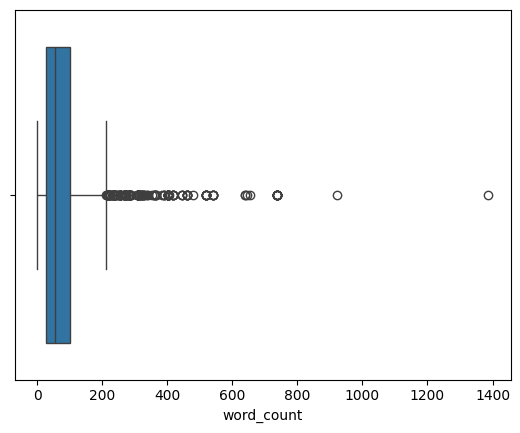

In [43]:
# plot boxplot to look for outliars
sns.boxplot(x = X_train["word_count"])
plt.show()

In [44]:
X_train[X_train["word_count"] <= 3]["host_about"].head(15)

2858                                    Young architect. 
807                                             _x000D_\n
110                                             _x000D_\n
3706                                            Ruan&Chen
2181                                        Empreendedor 
751                                         Atalho solene
584                                                    :)
3024                                 Sandra Miranda Gomes
5547    Família_x000D_\nPortugal_x000D_\nGavião_x000D_...
5064                                            Architect
2519                                   João's Apartments 
2107                                                 \n\n
57                      我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作. 
3426                                Mouraria Lisboa Hotel
2254                                                 \n\n
Name: host_about, dtype: object

### Patterns:

In [45]:
#License Number
pattern = r'license number.*$'
X_train[X_train['host_about'].str.contains(pattern, regex=True)]

,index,description,host_about,unlisted,word_count


In [46]:
#html
pattern = r'<[a-zA-Z/][^>]*>?'
X_train[X_train['host_about'].str.contains(pattern, regex=True)]

,index,description,host_about,unlisted,word_count
820,821,Comfort ensuite room with double bed for 2 per...,"<a href="" (Website hidden by Airbnb) rel=""nofo...",0,12
5330,5331,Baixa Guest House is close to all the touristi...,"<a href="" (Website hidden by Airbnb) rel=""nofo...",0,12


In [47]:
pattern = r'_x000D_\n' #excel
X_train[X_train['host_about'].str.contains(pattern, regex=True)].head(2)

,index,description,host_about,unlisted,word_count
6060,6061,Charming apartment inside a luxury condominium...,I’m from Lisbon and I Like to travel around th...,1,54
1039,1040,NOVO! O Tropical Pool View - Checkinhome é um ...,Olá! Chamo-me Cláudia Diniz e sou responsável ...,1,63


In [48]:
#currency symbols
X_train['currency_symbols'] = X_train['host_about'].apply(find_currency)
filtered_df = X_train[X_train['currency_symbols'].apply(lambda x: len(x) > 0)]
print(filtered_df[['host_about', 'currency_symbols']].head(3))

Empty DataFrame
Columns: [host_about, currency_symbols]
Index: []


In [49]:
#usernames
pattern = r'@\b[a-zA-Z0-9._]{3,15}\b'
X_train[X_train['host_about'].str.contains(pattern, regex=True)].head(2)

,index,description,host_about,unlisted,word_count,currency_symbols
1634,1635,+Private attic with a bathtub (bathroom)<br />...,"Óla, fellow traveler!\n\nMy name is Tin.\nI'm ...",1,131,[]
1425,1426,Our apartments gives you the opportunity to ex...,@ZMPoppe\n,1,1,[]


In [50]:
#emails
pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
X_train[X_train['host_about'].str.contains(pattern, regex=True)]

,index,description,host_about,unlisted,word_count,currency_symbols


In [51]:
#URL links
pattern =  r'http\S+|www\S+'
X_train[X_train['host_about'].str.contains(pattern, regex=True)].head(2)

,index,description,host_about,unlisted,word_count,currency_symbols
1634,1635,+Private attic with a bathtub (bathroom)<br />...,"Óla, fellow traveler!\n\nMy name is Tin.\nI'm ...",1,131,[]
471,472,Bright & Modern apartment w/ Elevator & A/C is...,List of Our Aparments: https://www.airbnb.pt/w...,0,99,[]


In [52]:
X_train.drop(columns = ["word_count", "currency_symbols"], inplace = True)

## X_train_reviews

In [53]:
X_train_reviews["index"].value_counts()

index
265     888
3396    764
1147    678
4106    617
954     583
       ... 
1411      1
4746      1
6092      1
4668      1
3121      1
Name: count, Length: 3619, dtype: int64

In [54]:
exploration = X_train_reviews[X_train_reviews["comments"].str.contains("<b", na=False)]
exploration.head(2)

,index,comments
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."


In [55]:
X_train_reviews[X_train_reviews['comments'].str.contains('<b', na = False)]["comments"]

1                                                 good<br/>
2         My first hostel experience, and all I have to ...
3         Das Hostel war neu und deshalb funktionierte a...
17        Everything is correct, like the photos said. B...
18        Je trouve le logement cher pour une auberge de...
                                ...                        
361269    La ubicación es muy buena , el trato con la an...
361275    Definetly good location. Apartment was cozy an...
361276    The location was perfect. The apartment was ve...
361279    No wifi nor answer. <br/>The wifi can’t be con...
361280    O espaço é ótimo, a D. Ana foi maravilhosa e f...
Name: comments, Length: 78489, dtype: object

In [56]:
X_train_reviews['word_count']  = X_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
X_train_reviews[['comments','word_count']].head()

C:\Users\Adriana\AppData\Local\Temp\ipykernel_15148\3418589424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reviews['word_count']  = X_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))


,comments,word_count
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


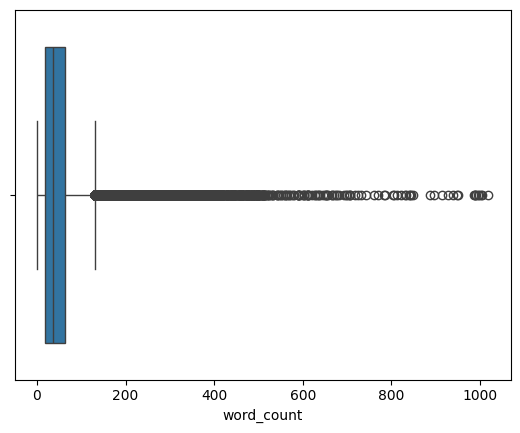

In [57]:
# plot boxplot to look for outliars
sns.boxplot(x = X_train_reviews["word_count"])
plt.show()

In [58]:
X_train_reviews[X_train_reviews["word_count"] <= 5]["comments"].head(20)

1                                    good<br/>
10                     Well located and clean.
11                       Good value for money.
12             Good stay with reasonable price
13                                  Very Nice.
14               Bonne auberge pour les jeunes
21                               Awesome place
26                        You have to be there
28             Estão de parabéns super indico.
29                 Great stay! Would recommend
34                    Очень хороший хостел !!!
35                      Очень хороший хостел !
36                  Отличный хостел, советую !
37               Super accueil, chambre propre
39                                         top
65                                  Recomendo.
75          Spectacular location, awsome place
84                perfect view over the beach.
85    Excelente localização, e vista perfeita.
86                             Tudo agradável.
Name: comments, dtype: object

In [59]:
# currency symbols
X_train_reviews['currency_symbols'] = X_train_reviews['comments'].apply(find_currency)

filtered_df = X_train_reviews[X_train_reviews['currency_symbols'].apply(lambda x: len(x) > 0)]

filtered_df[['comments', 'currency_symbols']].head(3)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_15148\3857128129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reviews['currency_symbols'] = X_train_reviews['comments'].apply(find_currency)


,comments,currency_symbols
18,Je trouve le logement cher pour une auberge de...,"[(, 78€)]"
446,I made a booking with Airbnb from the 21 Febru...,"[(, 400€)]"
956,Très bon emplacement pour visiter Lisbonne à p...,"[(, 25€), (, 20€)]"


In [60]:
#License Number
pattern = r'license number.*$'
X_train_reviews[X_train_reviews['comments'].str.contains(pattern, regex=True)]

,index,comments,word_count,currency_symbols


In [61]:
#excel
pattern = r'_[xX]000[dD]_'
X_train_reviews[X_train_reviews['comments'].str.contains(pattern, regex=True)]

,index,comments,word_count,currency_symbols
2,1,"My first hostel experience, and all I have to ...",261,[]
3,1,Das Hostel war neu und deshalb funktionierte a...,81,[]
1132,25,It was a very nice flat and especially the bal...,87,[]
1134,25,Sandra is the sweetest_x000D_<br/>the apartme...,58,[]
1139,25,Am morgen das Erwachen der Stadt beim Frühstüc...,51,[]
...,...,...,...,...
360849,6245,The apartement is just amazing! It's exactly h...,84,[]
360852,6245,I had a really good time in this flat!_x000D_<...,34,[]
360854,6245,Appartement idéalement situé._x000D_<br/>Bien ...,26,[]
360855,6245,"Gostaria de agradecer aos anfitriões e, em esp...",64,[]


In [62]:
#html
pattern = r'<[a-zA-Z/][^>]*>?'
X_train_reviews[X_train_reviews['comments'].str.contains(pattern, regex=True)]

,index,comments,word_count,currency_symbols
1,1,good<br/>,1,[]
2,1,"My first hostel experience, and all I have to ...",261,[]
3,1,Das Hostel war neu und deshalb funktionierte a...,81,[]
17,1,"Everything is correct, like the photos said. B...",24,[]
18,1,Je trouve le logement cher pour une auberge de...,87,"[(, 78€)]"
...,...,...,...,...
361269,6248,"La ubicación es muy buena , el trato con la an...",42,[]
361275,6248,Definetly good location. Apartment was cozy an...,20,[]
361276,6248,The location was perfect. The apartment was ve...,131,[]
361279,6248,No wifi nor answer. <br/>The wifi can’t be con...,20,[]


In [63]:
#usernames
pattern = r'@\b[a-zA-Z0-9._]{3,15}\b'
X_train_reviews[X_train_reviews['comments'].str.contains(pattern, regex=True)]

,index,comments,word_count,currency_symbols
27467,493,"Dear Patrícia,<br/>Thank you so much that we c...",118,[]
31309,547,João’s place was great! João was very easy to ...,98,[]
32772,576,What a fantastic apartment! It has everything ...,116,[]
32780,576,We had a great time at Nest@Lisbon’s place. Th...,60,[]
40646,716,@Pedro is communicative and affable - a great ...,141,[]
42879,759,"Mottagandet var strålande, värden Nuno hämtade...",55,[]
64207,1090,Tudo perfeito. Já é a segunda vez que ficamos ...,35,[]
83169,1391,Where to start...? Everything was great about ...,78,[]
83207,1391,This is a fantastic apartment in a good neighb...,181,[]
83268,1391,Henrique and Pedro from Nest@Lisbon demonstrat...,50,[]


In [64]:
#emails
pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
X_train_reviews[X_train_reviews['comments'].str.contains(pattern, regex=True)]

,index,comments,word_count,currency_symbols
108220,1838,Spędziliśmy 7 dni u gospodarza w lipcu. Doskon...,73,[]
118125,2000,"Não recomendo, de todo, o alojamento. Explico ...",989,[]
131838,2234,"Great spot, clean etc. Any questions about get...",16,[]
151362,2569,Un véritable paradis Très très bien situé (tou...,94,[]
160421,2699,This apartment is as advertised and is conveni...,53,[]
201215,3428,"Bonjour,<br/>Notre expérience chez Maria a été...",399,[]
262201,4478,L'appartement est très bien situé dans le quar...,155,[]
319429,5575,"Appartement conforme aux photos. Accueillant, ...",159,[]


In [65]:
#dates
pattern =  r'\b(?:\d{1,2}[-/]\d{1,2}[-/](?:\d{2}|\d{4})|\d{4}[-/]\d{1,2}[-/]\d{1,2})\b'
X_train_reviews[X_train_reviews['comments'].str.contains(pattern, regex=True)].head(2)

,index,comments,word_count,currency_symbols
4169,70,We have stay in Taynara's appartment for 15 da...,124,[]
21180,388,I stayed at this appartment from 11/9/2022 unt...,142,[]


In [66]:
#numerical values
pattern =  r'\b\w*[a-zA-Z]+\d+\w*|\w*\d+[a-zA-Z]+\w*\b'
X_train_reviews[X_train_reviews['comments'].str.contains(pattern, regex=True)].head(2)

,index,comments,word_count,currency_symbols
2,1,"My first hostel experience, and all I have to ...",261,[]
3,1,Das Hostel war neu und deshalb funktionierte a...,81,[]


### Visualization of comments per listing

In [67]:
X_train_reviews.head(1)

,index,comments,word_count,currency_symbols
0,1,this is a very cozy and comfortable house to s...,28,[]


In [68]:
X_train_reviews["index"].duplicated().sum()

304940

Text(0.5, 1.0, 'Comments per Property')

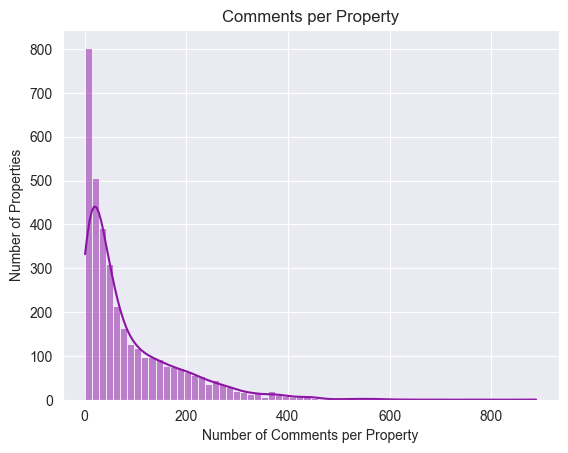

In [69]:
sns.set_style("darkgrid")

comments_count = X_train_reviews.groupby('index').count()['comments']
sns.histplot(data=comments_count, kde=True, color= "#8C14A4")

plt.xlabel('Number of Comments per Property')
plt.ylabel('Number of Properties')
plt.title('Comments per Property')

In [70]:
X_train_reviews.groupby('index').count()['comments'].describe()

count    3619.000000
mean       85.260846
std        97.289262
min         1.000000
25%        17.000000
50%        47.000000
75%       123.500000
max       888.000000
Name: comments, dtype: float64

c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


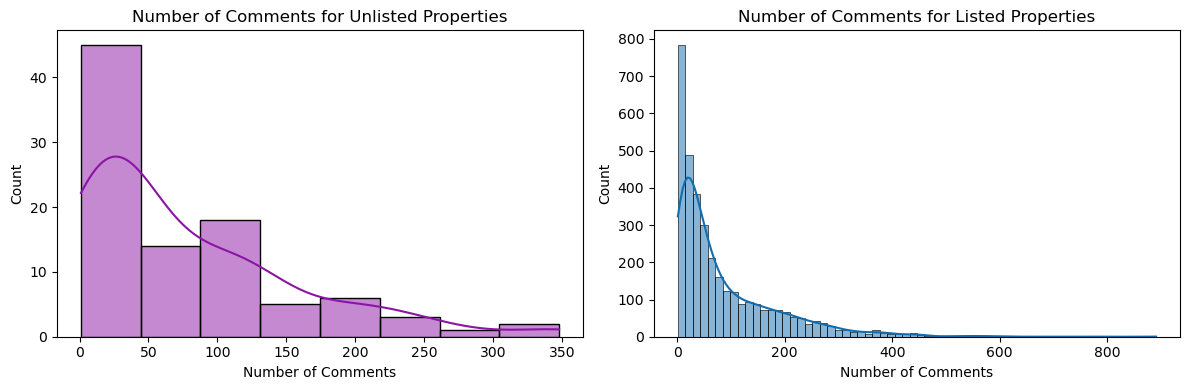

In [ ]:
comments_count = X_train_reviews.groupby('index').count()['comments']

merged_df = X_train_reviews.merge(X_train, on='index')

unlisted_true = comments_count[merged_df['unlisted'] == 1]
unlisted_false = comments_count[merged_df['unlisted'] == 0]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

sns.histplot(data=unlisted_true, color='#8C14A4', ax=axes[0], kde = True)
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Count')
axes[0].set_title('Number of Comments for Unlisted Properties')

sns.histplot(data=unlisted_false, color='#136CAE', ax=axes[1], kde = True)
axes[1].set_xlabel('Number of Comments')
axes[1].set_ylabel('Count')
axes[1].set_title('Number of Comments for Listed Properties')

plt.tight_layout()
plt.show()

In [72]:
X_train_reviews.drop(columns = ["currency_symbols"], inplace = True)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_15148\2299474796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reviews.drop(columns = ["currency_symbols"], inplace = True)


## Language

In [73]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

In [74]:
def plot_languages(lang_data):
    fig, ax = plt.subplots(figsize=(8,6))
    sns.countplot(y = lang_data, order = lang_data.value_counts().index.tolist(), ax = ax)

    ax.set_xlabel('Frequency')
    ax.set_ylabel('Languages')

    for i in ax.containers:
        ax.bar_label(i, label_type = 'edge')

    plt.show()

In [75]:
def plot_languages(lang_data, ax):
    sns.countplot(y=lang_data, order=lang_data.value_counts().index.tolist(), ax=ax)
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Languages')

    total = len(lang_data)
    
    for container in ax.containers:
        labels = [f'{(v.get_width() / total) * 100:.1f}%' for v in container]
        ax.bar_label(container, labels=labels, label_type='edge')

In [76]:
description_lang = X_train['description'].apply(lambda x: detect_language(str(x)))
comments_lang = X_train_reviews['comments'].apply(lambda x: detect_language(str(x)))
host_about_lang = X_train['host_about'].apply(lambda x: detect_language(str(x)))

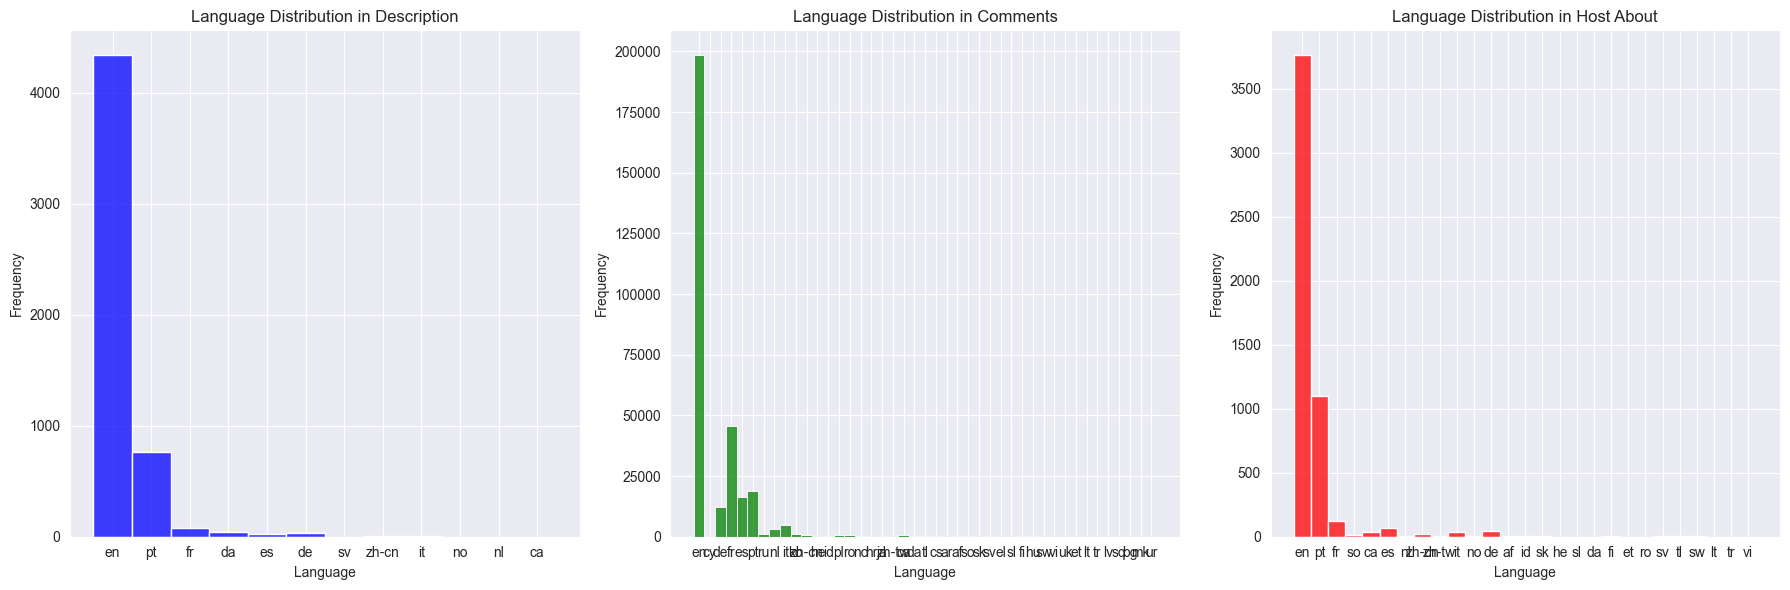

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Description Language Distribution
sns.histplot(description_lang, ax=axes[0], color='blue')
axes[0].set_title('Language Distribution in Description')
axes[0].set_xlabel('Language')
axes[0].set_ylabel('Frequency')

# Comments Language Distribution
sns.histplot(comments_lang, ax=axes[1], color='green')
axes[1].set_title('Language Distribution in Comments')
axes[1].set_xlabel('Language')
axes[1].set_ylabel('Frequency')

# Host_about Language Distribution
sns.histplot(host_about_lang, ax=axes[2], color='red')
axes[2].set_title('Language Distribution in Host About')
axes[2].set_xlabel('Language')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

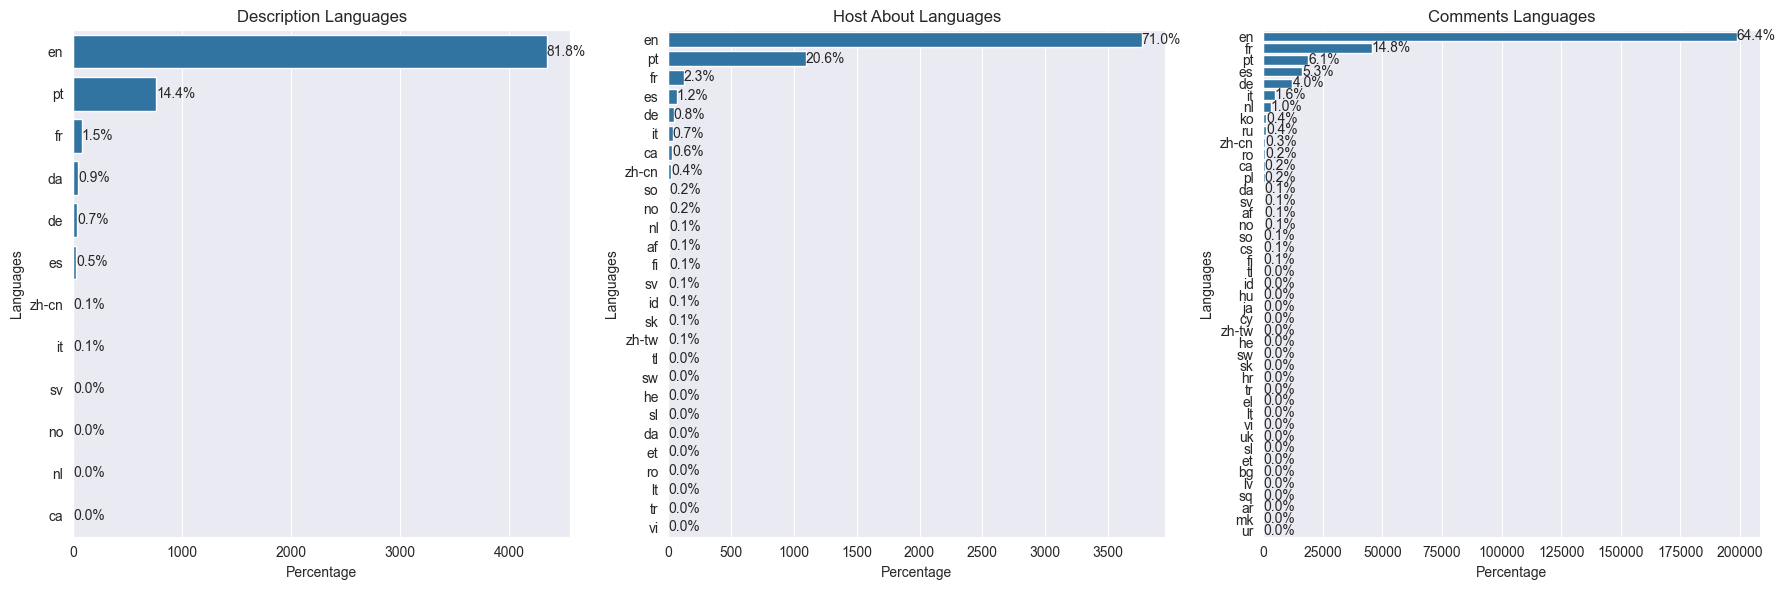

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  


plot_languages(description_lang, axes[0])
axes[0].set_title('Description Languages')

plot_languages(host_about_lang, axes[1])
axes[1].set_title('Host About Languages')

plot_languages(comments_lang, axes[2])
axes[2].set_title('Comments Languages')

plt.tight_layout()  
plt.show()

Upon investigation of the graphs above, we have decided to only continue with the following languages:

* English
* French
* Spanish
* Portuguese
* Deutsch

It's important to note, most algorithms that work with languages aren't compatible with the long list present in this dataset. Therefore, we decided to only choose more relevant ones.

## Analysing Text

### Special Characters: Uni Codes (Extra)

In [79]:
def special_characters(text, char_counts):
    for char in text:
        if not char.isalnum() and char not in string.punctuation and not char.isnumeric() and not regex.match(r'\p{Sc}', char):
            char_counts[char] = char_counts.get(char, 0) + 1

In [80]:
count = {}
X_train_reviews["comments"].apply(lambda x: special_characters(x, count))
print(count)

{' ': 14502960, '´': 880, '’': 63046, '😊': 1112, '🇧': 6, '🇷': 3, '🤓': 3, '👌': 456, '🏻': 371, '—': 1110, '，': 5244, '。': 2377, '…': 1992, '“': 1256, '”': 1084, '‘': 1396, '–': 579, '😁': 199, '👍': 1172, '☀': 90, '️': 1460, '❤': 533, '🙂': 251, '😀': 199, '⭐': 384, '🙏': 239, '\xa0': 927, '☺': 379, '！': 720, '🥰': 129, '♥': 81, '«': 213, '»': 209, '🤩': 91, '、': 528, '🤍': 13, '🏽': 140, '😄': 76, '😍': 199, '😉': 321, '😘': 57, '🇵': 56, '🇹': 56, '¡': 327, '🤗': 88, '°': 284, '،': 5, '„': 212, '💙': 16, '😅': 76, '😂': 61, '🥶': 3, '☕': 6, '🏼': 317, '😇': 21, '\u200b': 101, '̃': 3, '́': 37, '✨': 93, '🥂': 6, '💜': 14, '🙋': 12, '\u200d': 42, '♀': 24, '😎': 75, '😃': 130, '✌': 38, '🌟': 88, '💚': 24, '🏖': 5, '🌴': 5, '🍽': 2, '🙌': 67, '😌': 28, '\uf04a': 10, '🎂': 4, '😒': 1, '😔': 4, '🤙': 16, '～': 56, '😻': 6, '😳': 7, '😏': 11, '🤦': 3, '♂': 11, '🌞': 54, '🍷': 21, '💯': 38, '💎': 8, '🤣': 22, '🤌': 4, '💗': 18, '😬': 15, '👐': 1, '👊': 1, '\ufeff': 2, '👏': 117, '🚌': 3, '💥': 7, '🏴': 1, '\U000e0067': 1, '\U000e0062': 1, '\U000e0077

In [81]:
count = {}
X_train["description"].apply(lambda x: special_characters(x, count))
print(count)

{' ': 698561, '’': 1027, '®': 1, '—': 45, '→': 43, '´': 212, '–': 197, '“': 180, '”': 178, '»': 33, '«': 10, '•': 214, '…': 37, '★': 23, '￫': 284, '‘': 22, '，': 89, '。': 16, '\xa0': 251, '\u200b': 94, '\t': 64, '🙂': 1, '😊': 3, '😂': 1, '😉': 1, '¡': 4, '°': 21, '❤': 6, '️': 22, '➽': 19, '☝': 2, '☀': 8, '\ufeff': 1, '︎': 4, '▲': 2, '☼': 4, '·': 11, '✔': 53, '⭐': 22, '●': 8, '！': 8, '💯': 1, '（': 5, '）': 7, '×': 3, '☺': 2, '▪': 8, '\uf076': 1, '✅': 12, '🏖': 1, '̧': 1, '́': 1, '±': 4, '♥': 2, '💙': 1, '：': 3, '、': 4, '；': 1, '・': 9, '📡': 2, '🌉': 2, '🌴': 2, '🚗': 1, 'ⓕ': 2, '☑': 6, '⚠': 1, '➸': 15, '🥳': 1, '🤗': 2, '🙌': 1, '🚙': 1, '🚕': 1, '🚇': 1, '》': 3, '✈': 1, '\U001000d3': 2, '\u2063': 1}


In [82]:
count = {}
X_train["host_about"].apply(lambda x: special_characters(x, count))
print(count)

{'’': 1286, ' ': 386073, '\n': 17366, '´': 363, '“': 260, '”': 331, '—': 67, '–': 145, '‘': 12, '…': 87, '\u200b': 56, '✈': 1, '️': 1, '»': 4, '，': 64, '\xa0': 29, '¿': 39, '¡': 8, '｡': 11, '､': 97, '。': 53, '｢': 3, '｣': 3, '°': 1, '！': 9, '́': 1, '•': 12, '\ufeff': 4, '«': 1}


#### Emojis (Extra):
https://pypi.org/project/emoji/

In [83]:
X_train_reviews[X_train_reviews["comments"].apply(lambda x: emoji.emoji_count(str(x)) > 0 and len(str(x)) < 5)]

,index,comments,word_count
432,11,👍,1
822,19,👍,1
5270,105,♥️,1
6049,129,💚,1
6132,130,👍,1
...,...,...,...
348999,6019,👍👍👍,1
351504,6068,👍,1
358818,6200,👍,1
359004,6202,👏,1


In [84]:
ex = train_reviews_df['comments'].iloc[348999]
print(ex)
print(emoji.demojize(ex))

👍👍👍
:thumbs_up::thumbs_up::thumbs_up:


In [85]:
# dealing with multiple followed emojis
ex = emoji.demojize(str(ex))
ex = ex.replace(':', ' : ') 
ex = ex.replace('_', ' _ ')
print(ex)

 : thumbs _ up :  : thumbs _ up :  : thumbs _ up : 


In [86]:
# dealing with emojis
ex = X_train_reviews['comments'].iloc[432]
print(ex)

Amazing stay at Patrick’s apartment! My husband and I met Luis, who was so friendly and welcoming. He was quick to respond and gave us tips on local things to do. The location was absolutely perfect, it had huge windows with tons of natural light, but they could easily be closed and covered to sleep in. The apartment faced a courtyard, so it was very peaceful and quiet with absolutely no street noise, even though we were in the heart of the city. <br/><br/>The apartment itself was stylish and well decorated, and there were so many thoughtful touches like trash cans, tissues, and outlets spaced throughout. The king bed was extremely comfortable. The high ceilings made the apartment feel enormous! We were so sad to leave and I would absolutely love to return.


In [87]:
# puntuaction will need to be removed
emoji.demojize(ex)

'Amazing stay at Patrick’s apartment! My husband and I met Luis, who was so friendly and welcoming. He was quick to respond and gave us tips on local things to do. The location was absolutely perfect, it had huge windows with tons of natural light, but they could easily be closed and covered to sleep in. The apartment faced a courtyard, so it was very peaceful and quiet with absolutely no street noise, even though we were in the heart of the city. <br/><br/>The apartment itself was stylish and well decorated, and there were so many thoughtful touches like trash cans, tissues, and outlets spaced throughout. The king bed was extremely comfortable. The high ceilings made the apartment feel enormous! We were so sad to leave and I would absolutely love to return.'

# Treating Outliers

In [ ]:
def detect_language_section(text, accepted_languages):
    pattern = r'(\n-{3,}\n|\n\*{3,}\n|\n_{3,}\n\nA|\n\nEm PORTUGUÊS\n\nA|\n\n_{3,}\n\n|\n_x000D_\n-[A-Z]+-_x000D_\n)'
    
    sections = re.split(pattern, text)
    
    for section in sections:
        try:
            lang = detect(section)
            if lang in accepted_languages:
                return section.strip()  
        except:
            continue
    
    return None  

def update_host_about(df, column_name='host_about'):
    accepted_languages = ['en', 'pt', 'es', 'fr', 'de']
    updated_descriptions = []
    for text in df[column_name]:
        new_description = detect_language_section(text, accepted_languages)
        if new_description:
            updated_descriptions.append(new_description)
        else:
            updated_descriptions.append(text)  

    df[column_name] = updated_descriptions
    return df

In [ ]:
X_train = update_host_about(X_train)
X_test = update_host_about(X_test)

# Clean 1

Where we treat firstly:
* Currencies
* Emails
* URL links
* Dates
* Numerical values
* EXCEL, HTML and 'License number' patterns
* Punctuation
* Emojis
* Hyphenized words
* Multiple spaces

In [ ]:
punctuation = string.punctuation
#!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

def replace_currency(text):
  pattern =  r'(\p{Sc}\s*[0-9]{1,3}(?:,[0-9]{3})*(?:\.[0-9]+)?)|([0-9]{1,3}(?:,[0-9]{3})*(?:\.[0-9]+)?\s*\p{Sc})'
  new_text = regex.sub(pattern, 'cost', text)
  return new_text


def replace_email(text):
  pattern =  r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
  new_text = regex.sub(pattern, 'email', text)
  return new_text

def replace_usernames(text):
  pattern =  r'@[A-Za-z0-9._-]+'
  new_text = regex.sub(pattern, 'username', text)
  return new_text

def replace_url(text):
  pattern =  r'http\S+|www\S+'
  new_text = regex.sub(pattern, 'url', text)
  return new_text

def replace_dates(text):
  pattern =  r'\b(?:\d{1,2}[-/]\d{1,2}[-/](?:\d{2}|\d{4})|\d{4}[-/]\d{1,2}[-/]\d{1,2})\b'
  new_text = regex.sub(pattern, 'date', text)
  return new_text

def replace_num_values(text):
  pattern =  r'\b\w*[a-zA-Z]+\d+\w*|\w*\d+[a-zA-Z]+\w*\b'
  new_text = regex.sub(pattern, 'number', text)
  return new_text


def remove_patterns(text, patterns):
    for pattern in patterns:
        text = re.sub(pattern, '', text)
    return text


def remove_special_characters(text):
    cleaned_text = ''
    for char in text:
        if char.isalnum() or char in string.punctuation or char.isspace() or regex.match(r'\p{Sc}', char):
            cleaned_text += char
    return cleaned_text

def replace_hyphen_with_space(text):
    return re.sub(r'([a-zA-Z0-9])-(?=[a-zA-Z0-9])', r'\1 ', text)

patterns = [
    r'_[xX]000[dD]_',  # Pattern 1: EXCEL
    r'license number.*$',  # Pattern 2: License number
    r'alojamento local registro.*$' #pt
    r'<[a-zA-Z/][^>]*>?' # Pattern 3: HTML tags
    r'<br\s*/?>' # Pattern 4: other HTML tags
]

In [ ]:
def clean1(text_list, patterns=[], demojize = True):
    updates = []

    for text in tqdm(text_list):
        # Lowercase text
        text = text.lower()

        # Remove hyphens 
        text = replace_hyphen_with_space(text)

        # Transform emojis into words with meaning
        if demojize:
            text = emoji.demojize(str(text))
            text = text.replace(':', ' : ')
            text = text.replace('_', ' _ ')

        # Remove specified patterns
        for pattern in patterns:
            text = re.sub(pattern, '', text)

        # Clean currency symbols
        text = replace_currency(text)

        # Clean usernames
        text = replace_usernames(text)

        # Clean emails
        text = replace_email(text)

        # Clean url links
        text = replace_url(text)

        # Clean dates  
        text = replace_dates(text)

        # Clean numerical values
        text = replace_num_values(text)

        # Clean special_characters and UNICODE
        text = remove_special_characters(text)

        # Clean roman numbers
        pattern = r'\bm{0,4}(?:cm|cd|d?c{0,3})(?:xc|xl|l?x{0,3})(?:ix|iv|v?i{0,3})\b'
        text = re.sub(pattern, '', text)

        text = re.sub(r'\b(\w+)[.,!?](\w+)\b', r'\1 \2', text)

        # Remove punctuation
        text = re.sub(f"[{string.punctuation}]", " ", text)
        
        # collapsing spaces
        text = re.sub(r'\s+', ' ', text).strip()

        updates.append(text)
        
    return updates

In [ ]:
X_train['description_clean1'] = clean1(X_train['description'], patterns=patterns)
X_train['host_clean1'] = clean1(X_train['host_about'], patterns=patterns)

X_test['description_clean1'] = clean1(X_test['description'], patterns=patterns)
X_test['host_clean1'] = clean1(X_test['host_about'], patterns=patterns)

X_train_reviews['comments_clean1'] = clean1(X_train_reviews['comments'], patterns=patterns)
X_test_reviews['comments_clean1'] = clean1(X_test_reviews['comments'], patterns=patterns)

100%|██████████| 52578/52578 [00:15<00:00, 3310.78it/s]


## Summarizing

In [ ]:
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Adriana\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
X_train_reviews['word_count_comments']  = X_train_reviews['comments_clean1'].apply(lambda x: len(str(x).split(" ")))
X_test_reviews['word_count_comments']  = X_test_reviews['comments_clean1'].apply(lambda x: len(str(x).split(" ")))

In [ ]:
filter_X_r_train = X_train_reviews[X_train_reviews["word_count_comments"] > 300].copy()
filter_X_r_test = X_test_reviews[X_test_reviews["word_count_comments"] > 300].copy()

In [ ]:
def summarize(text):
    input_ids = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True, 
        max_length=450 #diminui foi escolhido à toa
    )["input_ids"]
    
    output_ids = model.generate(
        input_ids=input_ids,
        max_length=84,
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]
    
    summary = tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )
    return summary

In [ ]:
filter_X_r_train['comments_summary'] = filter_X_r_train['comments_clean1'].apply(summarize)
filter_X_r_test['comments_summary'] = filter_X_r_test['comments_clean1'].apply(summarize)

### Saving in the original dfs

In [ ]:
X_train_reviews.loc[X_train_reviews["word_count_comments"] > 300, 'comments_clean1'] = filter_X_r_train['comments_summary']
X_test_reviews.loc[X_test_reviews["word_count_comments"] > 300, 'comments_clean1'] = filter_X_r_test['comments_summary']

In [ ]:
path_train = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_train_ml.pkl'
path_test = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_test_ml.pkl'
path_r_train = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_train_reviews.pkl'
path_r_test = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_test_reviews.pkl'

X_train.to_pickle(path_train)
X_test.to_pickle(path_test)
X_train_reviews.to_pickle(path_r_train)
X_test_reviews.to_pickle(path_r_test)

# Sentiment

In [ ]:
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
)

In [ ]:
sentiment_to_score = {
    'positive': 1,
    'neutral': 0.5,
    'negative': 0
}

def classify_sentiment(text):
    if text == 'not available':
        score = 0.5
    else:
        try:
            
            result = distilled_student_sentiment_classifier(text)
            if result and isinstance(result, list) and 'label' in result[0]:
                label = result[0]['label']
                score = sentiment_to_score.get(label, 0.5)
            else:
                score = 0.5
        except Exception as e:
            print(f"Error processing text '{text}': {e}")
            score = 0.5 
    return score

In [ ]:
X_train_reviews['sentiment_label'] = X_train_reviews['comments_clean1'].apply(classify_sentiment)
X_test_reviews['sentiment_label'] = X_test_reviews['comments_clean1'].apply(classify_sentiment)

Token indices sequence length is longer than the specified maximum sequence length for this model (1334 > 512). Running this sequence through the model will result in indexing errors


Error processing text '就是说这个房子总体还是不错的挺好的但是有几个问题真的没办法忽视 br br 首先是房东不和租客住一起有事沟通不及时我们都是给房东发消息反映问题而且一般来说住bnb应该是房东提供一些日用品比如洗洁精洗衣液啊什么的房东不住这我为了避免麻烦没有选择和室友们share这些我都是自己买的就这样我室友还特意来问我用什么东西洗衣服是怀疑我用她东西吗这是小问题不算什么 br br 然后吧这房子里面清洁工是大问题房东不住这里就没办法提供清洁清洁都是室友找了个清洁工每周来做但是问题是这个清洁工真的看人下菜碟所有人的费用都是汇总给其中一个室友然后由这个室友把这个钱转交那个清洁工就每次打扫那个室友的房间的时候特别认真打扫得很好很仔细我的房间她们就不那么认真马马虎虎5月份的时候清洁工一共来了五次其中3次 忘记 打扫我的房间我也不知道是为什么而且我5月就告诉她一定要好好清洁我的地毯拿吸尘器好好打扫我床下面可是6月的时候那个清洁工才告诉我地毯太脏了情节不了我趴着看床底下床底下也一层灰那个清洁工rosinha根本就是从来没打扫过我房间床底下也没清洁过我的地毯5月我给房东说过一回这个问题房东根本不管让我自己去解决 br br 还有就是房东实在是太funny太emotional她不是不负责任她挺好的我感觉到她尽力想要解决问题但是6月份的时候她自己违规收费然后反过来怪我然后说我为了一点小事大惊小怪我没有享受到我房间的清洁服务反而是我室友每次都让清洁工烫她自己的衬衫我凭什么当这个冤大头给室友的衬衫摊份子钱我这么当冤大头当了整整一个月交了48欧的清洁费结果有一天我下班特别早回来刚好抓到清洁工在那烫衬衫烫了两三小时合着你们都把我当人头呢我跟房东反映了这个问题房东反过来指责我不守信用我不守信用我能付48欧她一开始说30 35欧我不守信用能忍清洁工几次三番漏掉我房间的清洁说起这个我就生气一开始我体谅房子比较大清洁不是容易的事我同意了share清洁费结果全拿我涮着玩儿最后房东甚至说出if you don t make my life easy why do make yours 这种话我气得不行把她投诉了投诉到西班牙客服那里才解决 br br 房子冰箱从5月就坏了坏到了9月我走的时候还没换新的最热的7月8月我们没有冷冻室没办法制冰然后房子隔音真的不好门外有人说什么事情或

In [ ]:
# Lets calculate the average sentiment scores, since we plan to cut comments after when embedding them:

average_scores1 = X_train_reviews.groupby('index')['sentiment_label'].mean()
average_scores2 = X_test_reviews.groupby('index')['sentiment_label'].mean()

X_train_sentiment = average_scores1[average_scores1.index.isin(X_train['index'])]
X_test_sentiment = average_scores2[average_scores2.index.isin(X_test['index'])]

X_train = X_train.merge(X_train_sentiment, on='index', how='left')
X_test = X_test.merge(X_test_sentiment, on='index', how='left')

X_train['sentiment_label'].fillna(0.5, inplace=True)
X_test['sentiment_label'].fillna(0.5, inplace=True)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_31868\910884649.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['sentiment_label'].fillna(0.5, inplace=True)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_31868\910884649.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


# Multilingual DF:

In [ ]:
#Sometimes our clean functions clean too well, leaving empty lists. To resolve this issue:

def replace_empty_lists(text):
    if not text:  
        return 'not available'
    else:
        return text

X_train_reviews['comments_clean1'] = X_train_reviews['comments_clean1'].apply(replace_empty_lists)
X_train['host_clean1'] = X_train['host_clean1'].apply(replace_empty_lists)
X_train['description_clean1'] = X_train['description_clean1'].apply(replace_empty_lists)

X_test_reviews['comments_clean1'] = X_test_reviews['comments_clean1'].apply(replace_empty_lists)
X_test['host_clean1'] = X_test['host_clean1'].apply(replace_empty_lists)
X_test['description_clean1'] = X_test['description_clean1'].apply(replace_empty_lists)

# Some rows only have a space:
correct = 'not available'

X_train_reviews = X_train_reviews.applymap(lambda x: correct if x == ' ' else x)
X_train = X_train.applymap(lambda x: correct if x == ' ' else x)

X_test_reviews = X_test_reviews.applymap(lambda x: correct if x == ' ' else x)
X_test = X_test.applymap(lambda x: correct if x == ' ' else x)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\923022520.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train_reviews = X_train_reviews.applymap(lambda x: correct if x == ' ' else x)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\923022520.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = X_train.applymap(lambda x: correct if x == ' ' else x)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\923022520.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test_reviews = X_test_reviews.applymap(lambda x: correct if x == ' ' else x)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\923022520.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test = X_test.applymap(lambda x: correct if x == ' ' else x)


# Language Detection

In [ ]:
def language_detection(x):
  try:
    return detect(x)
  except:
    return 'error'

## Filtering the 5 languages we chose on the comments

* English
* French
* Spanish
* Portuguese
* Deutsch

In [ ]:
valid_languages = ['en', 'es', 'pt', 'fr', 'de']

X_train_reviews['comments_language'] = X_train_reviews['comments_clean1'].apply(language_detection)
X_test_reviews['comments_language'] = X_test_reviews['comments_clean1'].apply(language_detection)

X_train_reviews = X_train_reviews[
    (X_train_reviews['comments_language'].isin(valid_languages))]

X_test_reviews = X_test_reviews[
    (X_test_reviews['comments_language'].isin(valid_languages))]

### Saving df for transformer-based embeddings

In [ ]:
path_train = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_train_ml.pkl'
path_test = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_test_ml.pkl'
path_r_train = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_train_reviews_ml.pkl'
path_r_test = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_test_reviews_ml.pkl'

X_train.to_pickle(path_train)
X_test.to_pickle(path_test)
X_train_reviews.to_pickle(path_r_train)
X_test_reviews.to_pickle(path_r_test)

In [ ]:
X_train['description_language'] = X_train['description_clean1'].apply(language_detection)
X_train['host_about_language'] = X_train['host_clean1'].apply(language_detection)

X_test['description_language'] = X_test['description_clean1'].apply(language_detection)
X_test['host_about_language'] = X_test['host_clean1'].apply(language_detection)

# Clean2

Where we treat:
* Stop words
* Spell check
* Stemming
* Lemmatization


Tinhamos colocado aqui as contractions da Ana, mas acho que a minha função no clean1 já faz o mesmo

In [ ]:
stop_words = {
    "en" : set(stopwords.words('english')),
    "es" : set(stopwords.words('spanish')),
    "pt" : set(stopwords.words('portuguese')),
    "fr" : set(stopwords.words('french')),
    "de" : set(stopwords.words('german'))
}

def remove_stop_words(text, language):
  stop = stop_words.get(language, None)
  if stop:
    return " ".join([word for word in text.split() if word not in stop])
  else:
    return text
  


stemmers = {
    "en": SnowballStemmer("english"),
    "es": SnowballStemmer("spanish"),
    "pt": SnowballStemmer("portuguese"),
    "fr": SnowballStemmer("french"),
    "de": SnowballStemmer("german")
}

def stem_text(text, language):
  stemmer = stemmers.get(language, None)
  if stemmer: 
    return " ".join([stemmer.stem(word) for word in text.split()])
  else:
    return text



nlp = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm'),
    'pt': spacy.load('pt_core_news_sm'),
    'de': spacy.load('de_core_news_sm')
}

def lemmatize_text(text, lang):
    doc = nlp[lang](text)
    preprocessed_text = [token.lemma_ for token in doc]
    return preprocessed_text


patterns = [
    r'_[xX]000[dD]_',  # Pattern 1: EXCEL
    r'license number.*$',  # Pattern 2: License number
    r'alojamento local registro.*$' #pt
    r'<[a-zA-Z/][^>]*>?' # Pattern 3: HTML tags
    r'<br\s*/?>' # Pattern 4: other HTML tags
]

In [ ]:
def clean2(text_list, language, remove_stopwords=True, lemmatize=False, stem=False):
    updates = []
    valid_languages = ['en', 'es', 'pt', 'fr', 'de']

    for text, lang in tqdm(zip(text_list, language)):
        if lang not in valid_languages:
            updates.append(['not', 'available'])

        elif lang in valid_languages:
            # Clean special_characters and UNICODE
            text = remove_special_characters(text) # Summarize adds special characters

            # Remove stopwords
            text = remove_stop_words(text, lang)

            # wi-fi
            if lang == "en":
                text = contractions.fix(text)

            text = re.sub(r'\b(\w+)[.,!?](\w+)\b', r'\1 \2', text)

            # Remove punctuation
            text = re.sub(f"[{string.punctuation}]", " ", text) # Summarize adds punctuation

            # collapsing spaces
            text = re.sub(r'\s+', ' ', text).strip()


            # Lemmatize
            if lemmatize:
                text = lemmatize_text(text, lang)

            # Stemming
            if stem:
                text = stem_text(text, lang)

            updates.append(text)

        
    return updates

In [ ]:
def check_language(lang):
    valid_languages = ['en', 'es', 'pt', 'fr', 'de']
    if lang not in valid_languages:
        return 'en'
    return lang

X_train['description_language'] = X_train['description_language'].apply(check_language)
X_train['host_about_language'] = X_train['host_about_language'].apply(check_language)
X_train_reviews['comments_language'] = X_train_reviews['comments_language'].apply(check_language)

X_test_reviews['comments_language'] = X_test_reviews['comments_language'].apply(check_language)
X_test['description_language'] = X_test['description_language'].apply(check_language)
X_test['host_about_language'] = X_test['host_about_language'].apply(check_language)

In [ ]:
X_train['description_language'].value_counts()

description_language
en    4404
pt     763
fr      78
de      38
es      27
Name: count, dtype: int64

In [ ]:
X_train['description_clean2'] = clean2(X_train['description_clean1'], X_train['description_language'], remove_stopwords=True, lemmatize=True, stem = False)
X_train['host_about_clean2'] = clean2(X_train['host_clean1'], X_train['host_about_language'], remove_stopwords=True, lemmatize=True, stem = False)

X_test['description_clean2'] = clean2(X_test['description_clean1'], X_test['description_language'], remove_stopwords=True, lemmatize=True, stem = False)
X_test['host_about_clean2'] = clean2(X_test['host_clean1'], X_test['host_about_language'], remove_stopwords=True, lemmatize=True, stem = False)

X_train_reviews['comments_clean2'] = clean2(X_train_reviews['comments_clean1'], X_train_reviews['comments_language'], remove_stopwords=True, lemmatize=True, stem = False)
X_test_reviews['comments_clean2'] = clean2(X_test_reviews['comments_clean1'], X_test_reviews['comments_language'], remove_stopwords=True, lemmatize=True, stem = False)

5310it [00:43, 121.36it/s]
5310it [00:26, 203.49it/s]
938it [00:07, 123.80it/s]
938it [00:04, 205.53it/s]
291419it [19:05, 254.50it/s]
49677it [03:18, 250.62it/s]


In [ ]:
X_train.head(2)

,index,description,host_about,unlisted,description_clean1,host_clean1,description_language,host_about_language,description_clean2,host_about_clean2
6060,6061,Charming apartment inside a luxury condominium...,I’m from Lisbon and I Like to travel around th...,1,charming apartment inside a luxury condominium...,im from lisbon and like to travel around the w...,en,en,"[charming, apartment, inside, luxury, condomin...","[I, be, lisbon, like, travel, around, world, v..."
4076,4077,Amazing modern one bedroom apartment near Merc...,We are Feels Like Home Holiday Rentals.\nA com...,0,amazing modern one bedroom apartment near merc...,we are feels like home holiday rentals a compa...,en,en,"[amazing, modern, one, bedroom, apartment, nea...","[feel, like, home, holiday, rental, company, b..."


In [ ]:
#Sometimes our clean functions clean too well, leaving empty lists. To resolve this issue:

def replace_empty_lists(text):
    if not text:  
        return ['not', 'available']
    else:
        return text

X_train_reviews['comments_clean2'] = X_train_reviews['comments_clean2'].apply(replace_empty_lists)
X_train['host_about_clean2'] = X_train['host_about_clean2'].apply(replace_empty_lists)
X_train['description_clean2'] = X_train['description_clean2'].apply(replace_empty_lists)

X_test_reviews['comments_clean2'] = X_test_reviews['comments_clean2'].apply(replace_empty_lists)
X_test['host_about_clean2'] = X_test['host_about_clean2'].apply(replace_empty_lists)
X_test['description_clean2'] = X_test['description_clean2'].apply(replace_empty_lists)

In [ ]:
# Some rows only have a space:
correct = ['not', 'available']

X_train_reviews = X_train_reviews.applymap(lambda x: correct if x == ' ' else x)
X_train = X_train.applymap(lambda x: correct if x == ' ' else x)

X_test_reviews = X_test_reviews.applymap(lambda x: correct if x == ' ' else x)
X_test = X_test.applymap(lambda x: correct if x == ' ' else x)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\1550784888.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train_reviews = X_train_reviews.applymap(lambda x: correct if x == ' ' else x)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\1550784888.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = X_train.applymap(lambda x: correct if x == ' ' else x)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\1550784888.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test_reviews = X_test_reviews.applymap(lambda x: correct if x == ' ' else x)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_432\1550784888.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test = X_test.applymap(lambda x: correct if x == ' ' else x)


# Post Preprocessing Data Exploration

## Description Column

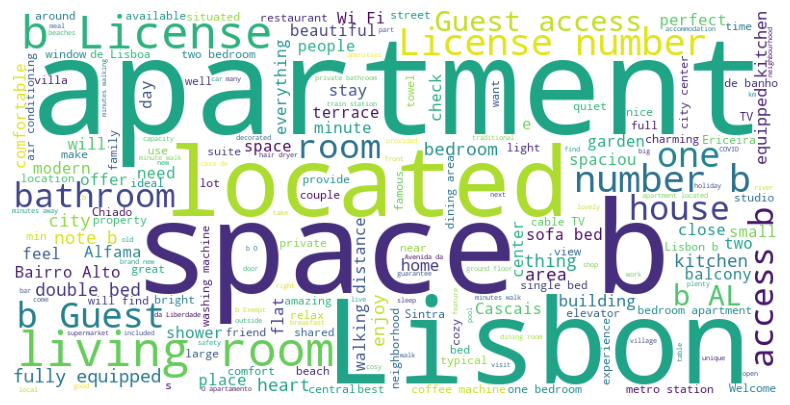

In [ ]:
all_descriptions = ' '.join(X_train['description'])
    
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_descriptions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

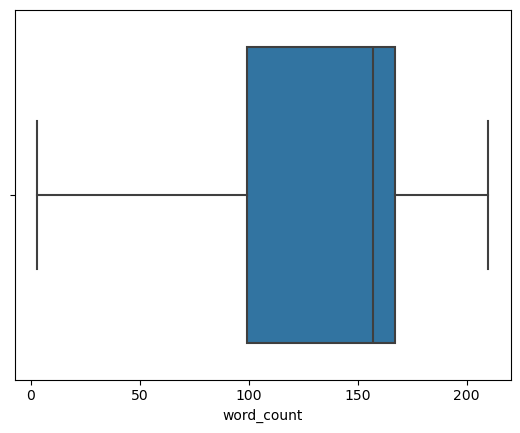

In [ ]:
X_train['word_count']  = X_train['description'].apply(lambda x: len(str(x).split(" ")))
sns.boxplot(x = X_train["word_count"])
plt.show()

## Host About Column

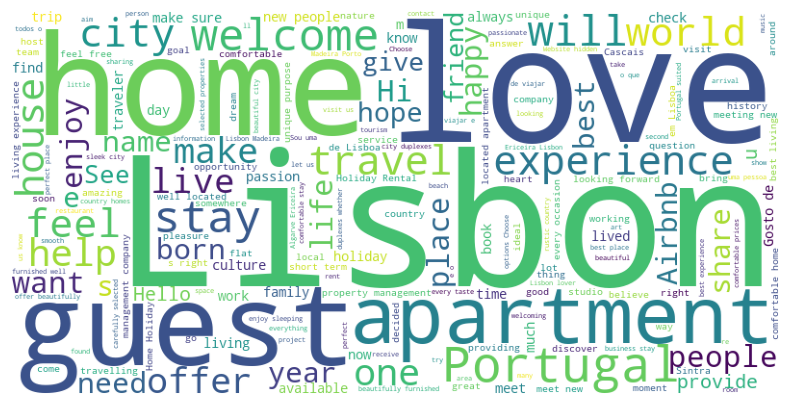

In [ ]:
all_descriptions = ' '.join(X_train['host_about'])
    
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_descriptions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

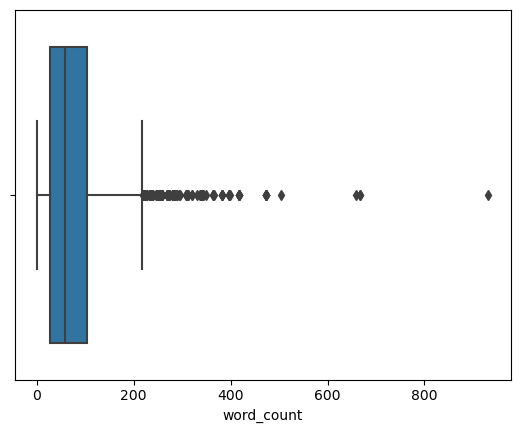

In [ ]:
X_train['word_count']  = X_train['host_about'].apply(lambda x: len(str(x).split(" ")))
sns.boxplot(x = X_train["word_count"])
plt.show()

## Comments Column

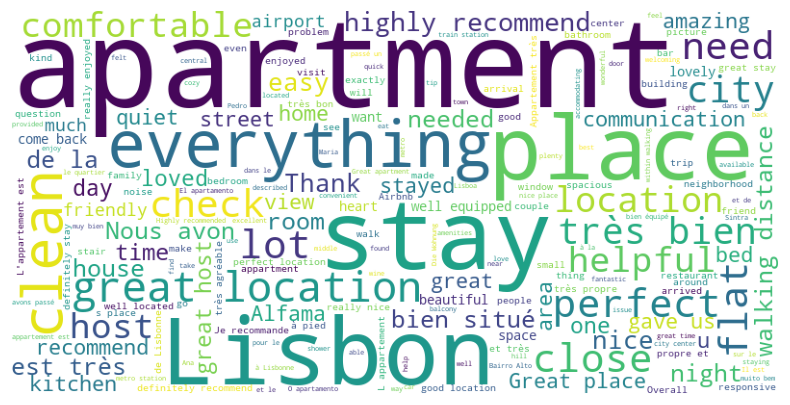

In [ ]:
all_descriptions = ' '.join(X_train_reviews['comments'])
    
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_descriptions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

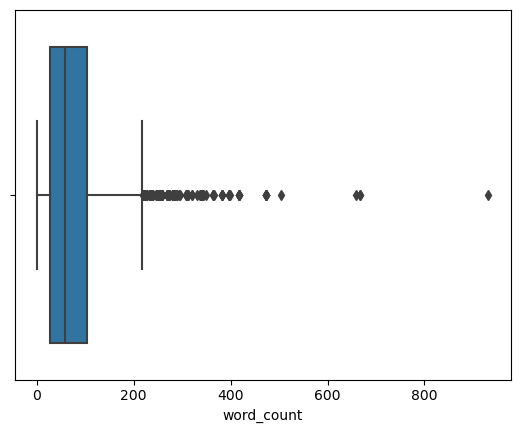

In [ ]:
X_train_reviews['word_count']  = X_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
sns.boxplot(x = X_train["word_count"])
plt.show()

# **Embeddings**

## FastText

this first part loads the vectors of the pretrain models of Fasttext and saves them as pickle so it's easier to load in the next runs. We only need to use this code one time and then we can just use the next part that loads the files we create here. 

In [ ]:
model_paths = {
    'english': r"C:\Users\Marta Branco\Documents\Programação_bea\fasttext\cc.en.300.bin.gz",
    'portuguese': r"C:\Users\Marta Branco\Documents\Programação_bea\fasttext\cc.pt.300.bin.gz",
    'french': r"C:\Users\Marta Branco\Documents\Programação_bea\fasttext\cc.fr.300.bin.gz",
    'spanish': r"C:\Users\Marta Branco\Documents\Programação_bea\fasttext\cc.es.300.bin.gz",
    'german': r"C:\Users\Marta Branco\Documents\Programação_bea\fasttext\cc.de.300.bin.gz"
}

ftx_models = {}

for language, model_path in model_paths.items():
    if os.path.exists(model_path):
        model_save_path = f'{language}_ftx_model.pkl' 
        if os.path.exists(model_save_path): 
            with gzip.open(model_save_path, 'rb') as f:
                ftx_models[language] = pickle.load(f)
        else:
            ftx_models[language] = load_facebook_vectors(model_path)
            with gzip.open(model_save_path, 'wb') as f: 
                pickle.dump(ftx_models[language], f)
    else:
        print(f'Model path for {language} does not exist: {model_path}')



In [ ]:
# this code loads the pkl with the saved models
# this is smother than running the files with vectors and saves us a lot of time
ftx_model_paths = {
    'en': '/Users/macbook/Documents/aulas_praticas/text mining/Project/Ftx_models/english_ftx_model.pkl',
    'pt': '/Users/macbook/Documents/aulas_praticas/text mining/Project/Ftx_models/portuguese_ftx_model.pkl',
    'fr': '/Users/macbook/Documents/aulas_praticas/text mining/Project/Ftx_models/french_ftx_model.pkl',
    'es': '/Users/macbook/Documents/aulas_praticas/text mining/Project/Ftx_models/spanish_ftx_model.pkl',
    'de': '/Users/macbook/Documents/aulas_praticas/text mining/Project/Ftx_models/german_ftx_model.pkl',
}

ftx_models = {}
for language, model_path in ftx_model_paths.items():
    with gzip.open(model_path, 'rb') as f:
        ftx_models[language] = pickle.load(f)

Two functions to do the embeddings
- first get's the token and aplies the correct embedding
- second handels rows and aplies the first one

In [ ]:
def get_ftx_embeddings(text, language):
    embeddings = []
    if language in ftx_models:
        for token in text:
            if token in ftx_models[language].key_to_index:
                embeddings.append(ftx_models[language][token])
    if embeddings:
        return embeddings
    else:
        return []

def apply_ftx_embeddings(text_column, language_column, row):
    language = row[language_column]
    text = row[text_column]
    if pd.notnull(language) and language in ftx_models:
        return get_ftx_embeddings(text, language)
    return []

Apply the function to 'host_about_clean' and 'description_clean' separately

In [ ]:
X_train['ftx_embeddings_host'] = X_train.apply(lambda row: apply_ftx_embeddings('host_about_clean2', 'host_about_language', row), axis=1)
X_train['ftx_embeddings_description'] = X_train.apply(lambda row: apply_ftx_embeddings('description_clean2', 'description_language', row), axis=1)

X_test['ftx_embeddings_host'] = X_test.apply(lambda row: apply_ftx_embeddings('host_about_clean2', 'host_about_language', row), axis=1)
X_test['ftx_embeddings_description'] = X_test.apply(lambda row: apply_ftx_embeddings('description_clean2', 'description_language', row), axis=1)

Apply function to X_reviews

In [ ]:
X_train_reviews['ftx_embeddings_comments'] = X_train_reviews.apply(lambda row: apply_ftx_embeddings('comments_clean2', 'comments_language', row), axis=1)
X_test_reviews['ftx_embeddings_comments'] = X_test_reviews.apply(lambda row: apply_ftx_embeddings('comments_clean2', 'comments_language', row), axis=1)

## Word2Vec

Similar to fasttext we have first a function that loads the txt files and saves them as models on a pickle file

In [ ]:
model_paths = {
    'english': '/Users/macbook/Documents/aulas_praticas/text mining/Project/word_vectors/enwiki_20180420_win10_100d.txt.bz2',
    'portuguese': '/Users/macbook/Documents/aulas_praticas/text mining/Project/word_vectors/ptwiki_20180420_100d.txt.bz2',
    'french': '/Users/macbook/Documents/aulas_praticas/text mining/Project/word_vectors/frwiki_20180420_100d.txt.bz2',
    'spanish': '/Users/macbook/Documents/aulas_praticas/text mining/Project/word_vectors/eswiki_20180420_100d.txt.bz2'
}


w2v_models = {}
for language, model_path in model_paths.items():
    if os.path.exists(model_path):
        model_save_path = f'{language}_w2v_model.pkl'  # Path to save the model
        if os.path.exists(model_save_path):  # Check if the model is already saved
            with open(model_save_path, 'rb') as f:
                w2v_models[language] = pickle.load(f)
        else:
            w2v_models[language] = KeyedVectors.load_word2vec_format(model_path, binary=False)
            with open(model_save_path, 'wb') as f:  # Save the model
                pickle.dump(w2v_models[language], f)

In [ ]:
# this code loads the pkl with the saved models
# this is smother than running the files with vectors and saves us a lot of time

w2v_model_paths = {
    'en': '/Users/macbook/Documents/aulas_praticas/text mining/Project/w2v_models/english_w2v_model.pkl',
    'pt': '/Users/macbook/Documents/aulas_praticas/text mining/Project/w2v_models/portuguese_w2v_model.pkl',
    'fr': '/Users/macbook/Documents/aulas_praticas/text mining/Project/w2v_models/french_w2v_model.pkl',
    'es': '/Users/macbook/Documents/aulas_praticas/text mining/Project/w2v_models/spanish_w2v_model.pkl',
    'de': '/Users/macbook/Documents/aulas_praticas/text mining/Project/w2v_models/german_w2v_model.pkl'
}

w2v_models = {}
for language, model_path in w2v_model_paths.items():
    with open(model_path, 'rb') as f:
        w2v_models[language] = pickle.load(f)

Two functions to do the embeddings
- first get's the token and aplies the correct embedding
- second handels rows and aplies the first one

In [ ]:
def get_w2v_embeddings(text, language):
    embeddings = []
    if language in w2v_models:
        for token in text:
            if token in w2v_models[language].key_to_index:
                embeddings.append(w2v_models[language][token])
    if embeddings:
        return embeddings
    else:
        return []

def apply_w2v_embeddings(text_column, language_column, row):
    language = row[language_column]
    text = row[text_column]
    if pd.notnull(language) and language in w2v_models:
        return get_w2v_embeddings(text, language)
    return []

Apply the function to 'host_about_clean' and 'description_clean' separately

In [ ]:
X_train['w2v_embeddings_host'] = X_train.apply(lambda row: apply_w2v_embeddings('host_about_clean2', 'host_about_language', row), axis=1)
X_train['w2v_embeddings_description'] = X_train.apply(lambda row: apply_w2v_embeddings('description_clean2', 'description_language', row), axis=1)

X_test['w2v_embeddings_host'] = X_test.apply(lambda row: apply_w2v_embeddings('host_about_clean2', 'host_about_language', row), axis=1)
X_test['w2v_embeddings_description'] = X_test.apply(lambda row: apply_w2v_embeddings('description_clean2', 'description_language', row), axis=1)

X_train_reviews['w2v_embeddings_comments'] = X_train_reviews.apply(lambda row: apply_w2v_embeddings('comments_clean2', 'comments_language', row), axis=1)
X_test_reviews['w2v_embeddings_comments'] = X_test_reviews.apply(lambda row: apply_w2v_embeddings('comments_clean2', 'comments_language', row), axis=1)

--------------------------------------------------

## Glove Embeddings

Similar to the other embeddings we have first a function that loads the txt file since for Glove we only found one model correctly trained for english. We also save it as a model on a pickle file.

In [ ]:
path_to_glove_file = "/Users/macbook/Documents/aulas_praticas/text mining/Project/word_vectors/glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

path_to_embeddings = "/Users/macbook/Documents/aulas_praticas/text mining/Project/word_vectors/glove_embeddings.pkl"

with open(path_to_embeddings, 'wb') as handle:
   pickle.dump(embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Embeddings saved to {path_to_embeddings}")

load the pkl for faster runs

In [ ]:
embeddings_index = pd.read_pickle(path_to_embeddings)

function to get the embeddings from the model

In [ ]:
def get_embedding_glove(text, embeddings_index, embedding_dim=100):
    embeddings = [embeddings_index.get(word) for word in text if word in embeddings_index]
    
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)
    
    return np.mean(embeddings, axis=0)

Apply the function to the Train data

In [ ]:
embedding_dim = 300

X_train['host_about_embedding'] = X_train['host_about_clean'].apply(lambda x: get_embedding_glove(x, embeddings_index, embedding_dim))
X_train['description_embedding'] = X_train['description_clean'].apply(lambda x: get_embedding_glove(x, embeddings_index, embedding_dim))

X_test['host_about_embedding'] = X_test['host_about_clean'].apply(lambda x: get_embedding_glove(x, embeddings_index, embedding_dim))
X_test['description_embedding'] = X_test['description_clean'].apply(lambda x: get_embedding_glove(x, embeddings_index, embedding_dim))


print(X_train[['host_about_embedding', 'description_embedding']].head())

--------------------------------------------------

## Saving the embeddings

## Fasttext

In [ ]:
text_for_nan = ['not', 'available']
text_for_nan = get_ftx_embeddings(text_for_nan, 'en')

# we only want one array so we do the mean
text_for_nan_mean = np.mean(text_for_nan, axis=0) 
text_for_nan_mean

array([-0.02681958,  0.04043972, -0.01745752,  0.13868633, -0.04944612,
       -0.01750839, -0.03082476, -0.04100066,  0.02043634, -0.02697935,
       -0.00315268,  0.00933148,  0.01232585, -0.00540651, -0.00134687,
        0.03724185,  0.00857708, -0.00889456, -0.00294998,  0.09905668,
        0.00131708, -0.00597025,  0.02164578,  0.01478316,  0.02497084,
       -0.01958286, -0.01146727,  0.01838501,  0.01588701,  0.01682865,
       -0.05609133,  0.00131517, -0.00291681,  0.03273924, -0.0275271 ,
       -0.00847446, -0.02225574, -0.01477979,  0.03282071, -0.01328847,
        0.00402395,  0.01309393,  0.04737923,  0.02900007,  0.00255694,
       -0.03929805, -0.0099418 , -0.05066033, -0.00158402, -0.0029263 ,
       -0.03146769,  0.00132914,  0.03824189, -0.00191194,  0.01948073,
        0.01945844, -0.02787634, -0.10546714, -0.11218054,  0.01678313,
       -0.03130152, -0.00141318, -0.0275242 , -0.07297353, -0.01973132,
       -0.03025001, -0.01980926, -0.03295668,  0.01744747, -0.00

### Train data

In [ ]:
# select only the columns we want to work with
X_train_selected_ftx = X_train[['index', 'ftx_embeddings_host', 'ftx_embeddings_description', 'unlisted']]
X_test_selected_ftx = X_test[['index', 'ftx_embeddings_host', 'ftx_embeddings_description', 'unlisted']]

# we only want one array so we do the mean
X_train_selected_ftx['ftx_embeddings_host']= X_train_selected_ftx['ftx_embeddings_host'].apply(lambda x: np.mean(x, axis=0))
X_train_selected_ftx['ftx_embeddings_description']= X_train_selected_ftx['ftx_embeddings_description'].apply(lambda x: np.mean(x, axis=0))

X_test_selected_ftx['ftx_embeddings_host']= X_test_selected_ftx['ftx_embeddings_host'].apply(lambda x: np.mean(x, axis=0))
X_test_selected_ftx['ftx_embeddings_description']= X_test_selected_ftx['ftx_embeddings_description'].apply(lambda x: np.mean(x, axis=0))

# group comments together by index, we will have an array with all vectors inside
X_train_grouped_ftx = X_train_reviews.groupby('index')['ftx_embeddings_comments'].agg(lambda x: sum([item if isinstance(item, list) else [] for item in x], []))
X_test_grouped_ftx = X_test_reviews.groupby('index')['ftx_embeddings_comments'].agg(lambda x: sum([item if isinstance(item, list) else [] for item in x], []))

# get the mean for the word vectors
mean_train_ftx = X_train_grouped_ftx.apply(lambda x: np.mean(x, axis=0))
mean_test_ftx = X_test_grouped_ftx.apply(lambda x: np.mean(x, axis=0))

# combine the two dataframes with merge
X_train_ftx = X_train_selected_ftx.merge(mean_train_ftx, on='index', how='left')
X_test_ftx = X_test_selected_ftx.merge(mean_test_ftx, on='index', how='left')

# fill NaN with the text we prepared above
X_train_ftx['ftx_embeddings_comments'].fillna(pd.Series([text_for_nan_mean] * len(X_train_ftx)), inplace=True)
X_test_ftx['ftx_embeddings_comments'].fillna(pd.Series([text_for_nan_mean] * len(X_test_ftx)), inplace=True)

# handling the empty list and any left nan values 
X_train_ftx['ftx_embeddings_host'] = X_train_ftx['ftx_embeddings_host'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_train_ftx['ftx_embeddings_description'] = X_train_ftx['ftx_embeddings_description'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_train_ftx['ftx_embeddings_comments'] = X_train_ftx['ftx_embeddings_comments'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)

X_test_ftx['ftx_embeddings_host'] = X_test_ftx['ftx_embeddings_host'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_test_ftx['ftx_embeddings_description'] = X_test_ftx['ftx_embeddings_description'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_test_ftx['ftx_embeddings_comments'] = X_test_ftx['ftx_embeddings_comments'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)

/Users/macbook/Documents/aulas_praticas/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/macbook/Documents/aulas_praticas/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xx/ktbh6j1d34v0ycmthd7psl8m0000gn/T/ipykernel_3339/2707559341.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected_ftx['ftx_embeddings_host']= X_train_selected_ftx['ftx_embeddings_host'].apply(lambda x: np.mean(x, axis=0))
/var/folders/xx/ktbh6j1d34v0ycmthd7psl8m0000gn/T/ipykernel_3339/2707559341.py:7: SettingWithCopyWarning: 
A valu

In [ ]:
X_train_ftx.to_pickle('/Users/macbook/Documents/aulas_praticas/text mining/Project/Embeddings/X_train_ftx_mean.pkl')
X_test_ftx.to_pickle('/Users/macbook/Documents/aulas_praticas/text mining/Project/Embeddings/X_test_ftx_mean.pkl')

--------------------------------------------------

## Word to Vec

In [ ]:
text_for_nan = ['not', 'available']
text_for_nan = get_w2v_embeddings(text_for_nan, 'en')

# we only want one array so we do the mean
text_for_nan_mean = np.mean(text_for_nan, axis=0) 
text_for_nan_mean

array([ 0.00505   , -0.10795   , -0.0034    , -0.0552    ,  0.1207    ,
       -0.3288    , -0.17985   , -0.2836    ,  0.24985   , -0.15685   ,
        0.14115   ,  0.20879999,  0.16385001, -0.0019    , -0.10325   ,
        0.48075002, -0.0372    , -0.227     ,  0.0031    ,  0.24485   ,
        0.04095   ,  0.3622    ,  0.24775001,  0.013     , -0.02455   ,
       -0.07265001, -0.11525   ,  0.2527    ,  0.0092    ,  0.066     ,
       -0.00825   ,  0.3996    ,  0.19260001,  0.10025001,  0.35044998,
        0.12435   , -0.3697    , -0.13685   , -0.00395   ,  0.22835   ,
        0.29065   ,  0.11765   , -0.5754    ,  0.31605   , -0.10235   ,
       -0.0049    ,  0.07615   , -0.44480002, -0.41195   , -0.0975    ,
       -0.09925   , -0.3689    , -0.04335   ,  0.2676    ,  0.0812    ,
        0.43485   ,  0.16104999,  0.10655   ,  0.05255   ,  0.2072    ,
       -0.099     , -0.0644    ,  0.02525   , -0.2335    , -0.0814    ,
       -0.30035   ,  0.0077    ,  0.15540001,  0.2603    , -0.10

In [ ]:
# select only the columns we want to work with
X_train_selected_w2v = X_train[['index', 'w2v_embeddings_host', 'w2v_embeddings_description', 'unlisted']]
X_test_selected_w2v = X_test[['index', 'w2v_embeddings_host', 'w2v_embeddings_description', 'unlisted']]

# we only want one array so we do the mean
X_train_selected_w2v['w2v_embeddings_host']= X_train_selected_w2v['w2v_embeddings_host'].apply(lambda x: np.mean(x, axis=0))
X_train_selected_w2v['w2v_embeddings_description']= X_test_selected_w2v['w2v_embeddings_description'].apply(lambda x: np.mean(x, axis=0))

X_test_selected_w2v['w2v_embeddings_host']= X_test_selected_w2v['w2v_embeddings_host'].apply(lambda x: np.mean(x, axis=0))
X_test_selected_w2v['w2v_embeddings_description']= X_test_selected_w2v['w2v_embeddings_description'].apply(lambda x: np.mean(x, axis=0))

# group comments together by index, we will have an array with all vectors inside
X_train_grouped_w2v = X_train_reviews.groupby('index')['w2v_embeddings_comments'].agg(lambda x: sum([item if isinstance(item, list) else [] for item in x], []))
X_test_grouped_w2v = X_test_reviews.groupby('index')['w2v_embeddings_comments'].agg(lambda x: sum([item if isinstance(item, list) else [] for item in x], []))

# get the mean for the word vectors
mean_train_w2v = X_train_grouped_w2v.apply(lambda x: np.mean(x, axis=0))
mean_test_w2v = X_test_grouped_w2v.apply(lambda x: np.mean(x, axis=0))

# combine the two dataframes with merge
X_train_w2v = X_train_selected_w2v.merge(mean_train_w2v, on='index', how='left')
X_test_w2v = X_test_selected_w2v.merge(mean_test_w2v, on='index', how='left')

# Fill NaN with the text we prepared above
X_train_w2v['w2v_embeddings_comments'].fillna(pd.Series([text_for_nan_mean] * len(X_train_w2v)), inplace=True)
X_test_w2v['w2v_embeddings_comments'].fillna(pd.Series([text_for_nan_mean] * len(X_test_w2v)), inplace=True)


# handling the empty list and any left nan values 
X_train_w2v['w2v_embeddings_host'] = X_train_w2v['w2v_embeddings_host'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_train_w2v['w2v_embeddings_description'] = X_train_w2v['w2v_embeddings_description'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_train_w2v['w2v_embeddings_comments'] = X_train_w2v['w2v_embeddings_comments'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)

X_test_w2v['w2v_embeddings_host'] = X_test_w2v['w2v_embeddings_host'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_test_w2v['w2v_embeddings_description'] = X_test_w2v['w2v_embeddings_description'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)
X_test_w2v['w2v_embeddings_comments'] = X_test_w2v['w2v_embeddings_comments'].apply(lambda x: text_for_nan_mean if isinstance(x, float) or (isinstance(x, list) and not x) else x)

/Users/macbook/Documents/aulas_praticas/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/macbook/Documents/aulas_praticas/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xx/ktbh6j1d34v0ycmthd7psl8m0000gn/T/ipykernel_3339/627735062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected_w2v['w2v_embeddings_host']= X_train_selected_w2v['w2v_embeddings_host'].apply(lambda x: np.mean(x, axis=0))
/var/folders/xx/ktbh6j1d34v0ycmthd7psl8m0000gn/T/ipykernel_3339/627735062.py:7: SettingWithCopyWarning: 
A value 

In [ ]:
X_train_w2v.to_pickle('/Users/macbook/Documents/aulas_praticas/text mining/Project/Embeddings/X_train_w2v_mean.pkl')
X_test_w2v.to_pickle('/Users/macbook/Documents/aulas_praticas/text mining/Project/Embeddings/X_test_w2v_mean.pkl')

--------------------------------------------------

## Multilingual Transformers Embeddings - EXTRA

## Load

In [ ]:
path_train = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_train_ml.pkl'
path_test = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_test_ml.pkl'
path_r_train = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_train_reviews_ml.pkl'
path_r_test = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Preprocess data\Multilingual\X_test_reviews_ml.pkl'

X_train = pd.read_pickle(path_train)
X_test = pd.read_pickle(path_test)
X_train_reviews = pd.read_pickle(path_r_train)
X_test_reviews = pd.read_pickle(path_r_test)

In [ ]:
# Reducing the comments, since we can't work with all of them
X_train_reviews['word_count']  = X_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))

X_train_reviews_shuffled = X_train_reviews.sample(frac=1, random_state=42) 

word_count = {}
rows_list = []

for _, row in X_train_reviews_shuffled.iterrows():
    index = row['index']
    comment = row['comments']
    
    if index not in word_count:
        word_count[index] = 0
    
    if word_count[index] + row['word_count'] <= 1000:
        rows_list.append(row)
        word_count[index] += row['word_count']
    elif word_count[index] < 800:
        continue

X_train_reviews_reduced = pd.DataFrame(rows_list)

In [ ]:
X_test_reviews['word_count']  = X_test_reviews['comments'].apply(lambda x: len(str(x).split(" ")))

X_test_reviews_shuffled = X_test_reviews.sample(frac=1, random_state=42) 

word_count = {}
rows_list = []

for _, row in X_test_reviews_shuffled.iterrows():
    index = row['index']
    comment = row['comments']
    
    if index not in word_count:
        word_count[index] = 0
    
    if word_count[index] + row['word_count'] <= 1000:
        rows_list.append(row)
        word_count[index] += row['word_count']
    elif word_count[index] < 800:
        continue

X_test_reviews_reduced = pd.DataFrame(rows_list)

In [ ]:
# Below, we'll embed our columns by the mean. To avoid calculating the mean of the mean when grouping comments together by index, 
# we will first group them together, and then embed them, to only calculate the mean once. This way we will have an array with all vectors inside.

train_comments_grouped_mbert = X_train_reviews_reduced.groupby('index')['comments'].agg(lambda x: ' '.join([str(item) for item in x if isinstance(item, str)]))
test_comments_grouped_mbert = X_test_reviews_reduced.groupby('index')['comments'].agg(lambda x: ' '.join([str(item) for item in x if isinstance(item, str)]))

X_train_reviews = train_comments_grouped_mbert[train_comments_grouped_mbert.index.isin(X_train['index'])]
X_test_reviews = test_comments_grouped_mbert[test_comments_grouped_mbert.index.isin(X_test['index'])]

# Merging the two dataframes:
X_train_w_sent = X_train.merge(X_train_reviews, on='index', how='left')
X_test_w_sent = X_test.merge(X_test_reviews, on='index', how='left')

#Since we're left joining the two dataframes, this means we will have NaN values for houses that do not have any comments. 
X_train_w_sent['comments'].fillna('not available', inplace=True)
X_test_w_sent['comments'].fillna('not available', inplace=True)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_31868\2239314544.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_w_sent['comments'].fillna('not available', inplace=True)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_31868\2239314544.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

## Multilingual BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

def extract_embeddings(encoded_input):
    encoded_input = {key: value.to(device) for key, value in encoded_input.items()}
    with torch.no_grad():
        output = model(**encoded_input)
    embeddings = output.last_hidden_state.mean(dim=1) 
    return embeddings

In [ ]:
def process_column_in_batches(dataframe, column_name, batch_size=32):
    all_embeddings = []

    for i in range(0, len(dataframe), batch_size):
        batch_texts = dataframe[column_name][i:i + batch_size].tolist()
        encoded_input = tokenize_texts(batch_texts)
        embeddings = extract_embeddings(encoded_input)
        all_embeddings.extend(embeddings.cpu().numpy())  

    return all_embeddings


In [ ]:
embeddings = process_column_in_batches(X_train_w_sent,'host_about')
X_train_w_sent['host_about_embeddings'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_test_w_sent,'host_about')
X_test_w_sent['host_about_embeddings'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_train_w_sent,'description')
X_train_w_sent['description_embeddings'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_test_w_sent,'description')
X_test_w_sent['description_embeddings'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_train_w_sent,'comments')
X_train_w_sent['comments_embeddings'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_test_w_sent,'comments')
X_test_w_sent['comments_embeddings'] = list(map(list, embeddings))

--------------------------------------------------

## XLM roBERTa

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

def extract_embeddings(encoded_input):
    encoded_input = {key: value.to(device) for key, value in encoded_input.items()}
    with torch.no_grad():
        output = model(**encoded_input)
    embeddings = output.last_hidden_state.mean(dim=1)
    return embeddings

In [ ]:
def process_column_in_batches(dataframe, column_name, batch_size=32):
    all_embeddings = []

    for i in range(0, len(dataframe), batch_size):
        batch_texts = dataframe[column_name][i:i + batch_size].tolist()
        encoded_input = tokenize_texts(batch_texts)
        embeddings = extract_embeddings(encoded_input)
        all_embeddings.extend(embeddings.cpu().numpy())

    return all_embeddings

In [ ]:
embeddings = process_column_in_batches(X_train_w_sent,'host_about')
X_train_w_sent['host_about_xlm'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_test_w_sent,'host_about')
X_test_w_sent['host_about_xlm'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_train_w_sent,'description')
X_train_w_sent['description_xlm'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_test_w_sent,'description')
X_test_w_sent['description_xlm'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_train_w_sent,'comments')
X_train_w_sent['comments_xlm'] = list(map(list, embeddings))

In [ ]:
embeddings = process_column_in_batches(X_test_w_sent,'comments')
X_test_w_sent['comments_xlm'] = list(map(list, embeddings))

## Exporting

In [ ]:
path_train = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Feature Engineering\X_train_w_sent.pkl'
path_test = r'C:\Users\Adriana\Documents\Faculdade\TM\Quase Finalizado\Feature Engineering\X_test_w_sent.pkl'

X_train_w_sent.to_pickle(path_train)
X_test_w_sent.to_pickle(path_test)

# **MODELS** - Predictive

## Logistic Regression

In [ ]:

def lr_with_sentiment(df, df_test, host, description, comments, sentiment):
    
    features = np.hstack([
        np.array(df[host].tolist()),        
        np.array(df[description].tolist()), 
        np.array(df[comments].tolist()),    
        df[sentiment].values.reshape(-1, 1) 
    ])
    labels = df['unlisted'].values

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    accuracies, f1_scores_class0, f1_scores_class1 = [], [], []

    for train_index, test_index in kf.split(features):
        X_train, X_val = features[train_index], features[test_index]
        y_train, y_val = labels[train_index], labels[test_index]

        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)

        y_val_pred = lr.predict(X_val)

        accuracies.append(accuracy_score(y_val, y_val_pred))
        f1 = f1_score(y_val, y_val_pred, average=None, labels=[0, 1])
        f1_scores_class0.append(f1[0])
        f1_scores_class1.append(f1[1])

    avg_accuracy = np.mean(accuracies)
    avg_f1_score_class0 = np.mean(f1_scores_class0)
    avg_f1_score_class1 = np.mean(f1_scores_class1)
    print("Average Results Across All Folds:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score for Class 0: {avg_f1_score_class0}")
    print(f"Average F1 Score for Class 1: {avg_f1_score_class1}")

    features_test = np.hstack([
        np.array(df_test[host].tolist()),        
        np.array(df_test[description].tolist()), 
        np.array(df_test[comments].tolist()),    
        df_test[sentiment].values.reshape(-1, 1) 
    ])
    labels_test = df_test['unlisted'].values

    y_test_pred = lr.predict(features_test)

    print("\nResults on Test Data:")
    print(f"Accuracy: {accuracy_score(labels_test, y_test_pred)}")
    print(f"F1 Score for Class 0: {f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[0]}")
    print(f"F1 Score for Class 1: {f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[1]}")
    print("\nClassification Report on Test Data:\n", classification_report(labels_test, y_test_pred))


## K Nearest Neighbors

In [ ]:
def knn_with_sentiment(df, df_test, host, description, comments, sentiment):

    features = np.hstack([
        np.array(df[host].tolist()),  
        np.array(df[description].tolist()), 
        np.array(df[comments].tolist()),    
        df[sentiment].values.reshape(-1, 1) 
    ])
    labels = df['unlisted'].values

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    accuracies, f1_scores_class0, f1_scores_class1 = [], [], []

    for train_index, test_index in kf.split(features):
        X_train, X_val = features[train_index], features[test_index]
        y_train, y_val = labels[train_index], labels[test_index]

        knn = KNeighborsClassifier(n_neighbors=5)  
        knn.fit(X_train, y_train)

        y_val_pred = knn.predict(X_val)

        accuracies.append(accuracy_score(y_val, y_val_pred))
        f1 = f1_score(y_val, y_val_pred, average=None, labels=[0, 1])
        f1_scores_class0.append(f1[0])
        f1_scores_class1.append(f1[1])

    avg_accuracy = np.mean(accuracies)
    avg_f1_score_class0 = np.mean(f1_scores_class0)
    avg_f1_score_class1 = np.mean(f1_scores_class1)

    print("Average Results Across All Folds:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score for Class 0: {avg_f1_score_class0}")
    print(f"Average F1 Score for Class 1: {avg_f1_score_class1}")

    features_test = np.hstack([
        np.array(df_test[host].tolist()),
        np.array(df_test[description].tolist()),
        np.array(df_test[comments].tolist()),
        df_test[sentiment].values.reshape(-1, 1)
    ])
    labels_test = df_test['unlisted'].values

    y_test_pred = knn.predict(features_test)

    print("\nResults on Test Data:")
    print(f"Accuracy: {accuracy_score(labels_test, y_test_pred)}")
    print(f"F1 Score for Class 0: {f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[0]}")
    print(f"F1 Score for Class 1: {f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[1]}")
    print("\nClassification Report on Test Data:\n", classification_report(labels_test, y_test_pred))


## Naive Bayes

In [ ]:
def nb_with_sentiment(df, df_test, host, description, comments, sentiment):
    features = np.hstack([
        np.array(df[host].tolist()),
        np.array(df[description].tolist()),
        np.array(df[comments].tolist()),
        df[sentiment].values.reshape(-1, 1)  
    ])
    labels = df['unlisted'].values

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    accuracies, f1_scores_class0, f1_scores_class1 = [], [], []

    for train_index, test_index in kf.split(features):
        X_train, X_val = features[train_index], features[test_index]
        y_train, y_val = labels[train_index], labels[test_index]
        
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)

        y_val_pred = gnb.predict(X_val)

        accuracies.append(accuracy_score(y_val, y_val_pred))
        f1 = f1_score(y_val, y_val_pred, average=None, labels=[0, 1])
        f1_scores_class0.append(f1[0])
        f1_scores_class1.append(f1[1])

    avg_accuracy = np.mean(accuracies)
    avg_f1_score_class0 = np.mean(f1_scores_class0)
    avg_f1_score_class1 = np.mean(f1_scores_class1)

    print("Average Results Across All Folds:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score for Class 0: {avg_f1_score_class0}")
    print(f"Average F1 Score for Class 1: {avg_f1_score_class1}")

    features_test = np.hstack([
        np.array(df_test[host].tolist()),
        np.array(df_test[description].tolist()),
        np.array(df_test[comments].tolist()),
        df_test[sentiment].values.reshape(-1, 1)  
    ])
    labels_test = df_test['unlisted'].values



    y_test_pred = gnb.predict(features_test)

    print("\nResults on Test Data:")
    print(f"Accuracy: {accuracy_score(labels_test, y_test_pred)}")
    print(f"F1 Score for Class 0: {f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[0]}")
    print(f"F1 Score for Class 1: {f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[1]}")
    print("\nClassification Report on Test Data:\n", classification_report(labels_test, y_test_pred))

## Multi-Layer Percepton

In [ ]:
def mlp_with_sentiment(df, df_test, host, description, comments, sentiment, input_size):

    X_host = np.array(df[host].tolist())
    X_desc = np.array(df[description].tolist())
    X_comm = np.array(df[comments].tolist())
    X_sent = np.array(df[sentiment].tolist()).reshape(-1, 1)
    y = df['unlisted'].values

    X_host_test = np.array(df_test[host].tolist())
    X_desc_test = np.array(df_test[description].tolist())
    X_comm_test = np.array(df_test[comments].tolist())
    X_sent_test = np.array(df_test[sentiment].tolist()).reshape(-1, 1)
    y_test = df_test['unlisted'].values

    num_folds = 5
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

    for train, test in kfold.split(X_host, y):
        tf.keras.backend.clear_session()  
        
        host_input = Input(shape=(input_size,))
        desc_input = Input(shape=(input_size,))
        comm_input = Input(shape=(input_size,))
        sent_input = Input(shape=(1,))
        
        host_dense = Dense(8, activation='relu')(host_input)
        desc_dense = Dense(8, activation='relu')(desc_input)
        comm_dense = Dense(8, activation='relu')(comm_input)
        sent_dense = Dense(8, activation='relu')(sent_input)
        
        concatenated = concatenate([host_dense, desc_dense, comm_dense, sent_dense])
        output = Dense(1, activation='sigmoid')(concatenated)
        
        model = Model(inputs=[host_input, desc_input, comm_input, sent_input], outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        model.fit([X_host[train], X_desc[train], X_comm[train], X_sent[train]], y[train], 
                  epochs=10, batch_size=32,
                  validation_data=([X_host[test], X_desc[test], X_comm[test], X_sent[test]], y[test]),
                  callbacks=[early_stopping])

    test_scores = model.evaluate([X_host_test, X_desc_test, X_comm_test, X_sent_test], y_test, verbose=0)
    test_preds = model.predict([X_host_test, X_desc_test, X_comm_test, X_sent_test])
    test_pred_classes = (test_preds > 0.5).astype(int)
    test_f1_macro = f1_score(y_test, test_pred_classes, average='macro')
    test_f1_micro = f1_score(y_test, test_pred_classes, average='micro')
    test_f1_weighted = f1_score(y_test, test_pred_classes, average='weighted')
    
    print("\nResults on Test Data:")
    print("Test Scores:", test_scores)
    print("Test F1 Score (Macro):", test_f1_macro)
    print("Test F1 Score (Micro):", test_f1_micro)
    print("Test F1 Score (Weighted):", test_f1_weighted)
    print("\nClassification Report on Test Data:\n", classification_report(y_test, test_pred_classes, target_names=['Class 0', 'Class 1']))

## XGBOOST - EXTRA

In [ ]:
def xgb_with_sentiment(df, df_test, host, description, comments, sentiment):

    features = np.hstack([
        np.array(df[host].tolist()),
        np.array(df[description].tolist()),
        np.array(df[comments].tolist()),
        df[sentiment].values.reshape(-1, 1)  # Reshape to align dimensions
    ])
    labels = df['unlisted'].values

    dtrain_full = xgb.DMatrix(features, label=labels)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    params_grid = {
        'max_depth': [3, 6, 10],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'eta': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300]
    }

    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    grid_search = GridSearchCV(estimator=model, param_grid=params_grid, scoring='accuracy', n_jobs=-1, cv=kf, verbose=1)
    grid_search.fit(features, labels)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

    features_test = np.hstack([
        np.array(df_test[host].tolist()),
        np.array(df_test[description].tolist()),
        np.array(df_test[comments].tolist()),
        df_test[sentiment].values.reshape(-1, 1)
    ])

    final_model = grid_search.best_estimator_

    y_test_pred = final_model.predict(features_test)

    print("\nResults on Test Data:")
    print("Accuracy: {:.2f}".format(accuracy_score(df_test['unlisted'].values, y_test_pred)))
    print("F1 Score for Class 0: {:.2f}".format(f1_score(df_test['unlisted'].values, y_test_pred, average=None, labels=[0, 1])[0]))
    print("F1 Score for Class 1: {:.2f}".format(f1_score(df_test['unlisted'].values, y_test_pred, average=None, labels=[0, 1])[1]))
    print("\nClassification Report on Test Data:\n", classification_report(df_test['unlisted'].values, y_test_pred))


## Random Forest - EXTRA

In [ ]:
def rf_with_sentiment(df, df_test, host, description, comments, sentiment):

    features = np.hstack([
        np.array(df[host].tolist()),
        np.array(df[description].tolist()),
        np.array(df[comments].tolist()),
        df[sentiment].values.reshape(-1, 1)  
    ])
    labels = df['unlisted'].values

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 150],  
        'max_features': ['auto', 'sqrt'],  
        'max_depth': [10, 20, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 4] 
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(features, labels)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

    features_test = np.hstack([
        np.array(df_test[host].tolist()),
        np.array(df_test[description].tolist()),
        np.array(df_test[comments].tolist()),
        df_test[sentiment].values.reshape(-1, 1)
    ])
    labels_test = df_test['unlisted'].values

    y_test_pred = grid_search.best_estimator_.predict(features_test)

    print("\nResults on Test Data:")
    print("Accuracy: {:.2f}".format(accuracy_score(labels_test, y_test_pred)))
    print("F1 Score for Class 0: {:.2f}".format(f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[0]))
    print("F1 Score for Class 1: {:.2f}".format(f1_score(labels_test, y_test_pred, average=None, labels=[0, 1])[1]))
    print("\nClassification Report on Test Data:\n", classification_report(labels_test, y_test_pred))

## FOR EMBEDDINGS

# FastText

In [ ]:
path_train = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\Mean\FT\X_train_ftx_mean.pkl"
train_df_fastText_sentiment = pd.read_pickle(path_train)
path_test =  r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\Mean\FT\X_test_ftx_mean.pkl"
test_df_fastText_sentiment = pd.read_pickle(path_test)

In [ ]:
train_df_fastText_sentiment.head(3)

,index,ftx_embeddings_host,ftx_embeddings_description,unlisted,ftx_embeddings_comments,sentiment_label
0,6061,"[-4.4625274e-05, 0.0044736685, -0.0073431022, ...","[-0.004822323, -0.06328164, -0.041360542, 0.02...",1,"[-0.026819585, 0.040439725, -0.017457515, 0.13...",0.500000
1,4077,"[0.01560808, -0.0023271076, 0.0027985591, 0.06...","[-0.0061423173, -0.06883565, -0.0074931392, -0...",0,"[0.00504155, -0.004990036, 0.0039533894, 0.032...",0.882353
2,1040,"[0.0038154821, -0.0092114955, 0.028597606, 0.0...","[0.02300335, 0.03362988, -0.023172852, -0.0784...",1,"[-0.026819585, 0.040439725, -0.017457515, 0.13...",0.500000


In [ ]:
test_df_fastText_sentiment.head(3)

,index,ftx_embeddings_host,ftx_embeddings_description,unlisted,ftx_embeddings_comments,sentiment_label
0,2165,"[-0.027367854, -0.022830734, 0.016791778, 0.01...","[0.01593751, -0.0047504893, 0.008870238, -0.04...",0,"[0.0005058897, -0.007311917, 0.004720363, 0.04...",1.000000
1,612,"[-0.024870742, 0.020720217, 0.079484925, 0.022...","[0.039584983, -0.07456466, 0.006394928, -0.003...",1,"[0.0045802253, -0.00628572, 0.0026488302, 0.03...",0.903226
2,3525,"[0.0008449456, 0.0059348973, 0.0005828255, 0.0...","[-0.0067488654, -0.070275865, 0.001456635, 0.0...",1,"[-0.026819585, 0.040439725, -0.017457515, 0.13...",0.500000


### Logistic Rregression

In [ ]:
lr_with_sentiment(train_df_fastText_sentiment, test_df_fastText_sentiment,'ftx_embeddings_host', 'ftx_embeddings_description','ftx_embeddings_comments' , 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.867231638418079
Average F1 Score for Class 0: 0.905802709286856
Average F1 Score for Class 1: 0.7747272303939559

Results on Test Data:
Accuracy: 0.8720682302771855
F1 Score for Class 0: 0.9088145896656534
F1 Score for Class 1: 0.7857142857142857

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       685
           1       0.72      0.87      0.79       253

    accuracy                           0.87       938
   macro avg       0.83      0.87      0.85       938
weighted avg       0.89      0.87      0.88       938



### K Nearest Neighbors

In [ ]:
knn_with_sentiment(train_df_fastText_sentiment, test_df_fastText_sentiment, 'ftx_embeddings_host', 'ftx_embeddings_description','ftx_embeddings_comments' , 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8674199623352166
Average F1 Score for Class 0: 0.9090746349058796
Average F1 Score for Class 1: 0.7548385219575323

Results on Test Data:
Accuracy: 0.8699360341151386
F1 Score for Class 0: 0.9114658925979681
F1 Score for Class 1: 0.7550200803212852

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       685
           1       0.77      0.74      0.76       253

    accuracy                           0.87       938
   macro avg       0.84      0.83      0.83       938
weighted avg       0.87      0.87      0.87       938



### Naive Bayes

In [ ]:
nb_with_sentiment(train_df_fastText_sentiment, test_df_fastText_sentiment, 'ftx_embeddings_host', 'ftx_embeddings_description','ftx_embeddings_comments' , 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8666666666666666
Average F1 Score for Class 0: 0.9052154343617083
Average F1 Score for Class 1: 0.77483980157585

Results on Test Data:
Accuracy: 0.8710021321961621
F1 Score for Class 0: 0.9077040427154844
F1 Score for Class 1: 0.7858407079646018

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       685
           1       0.71      0.88      0.79       253

    accuracy                           0.87       938
   macro avg       0.83      0.87      0.85       938
weighted avg       0.89      0.87      0.87       938



### Multi-Layered Percepton

In [ ]:
mlp_with_sentiment(train_df_fastText_sentiment, test_df_fastText_sentiment, 'ftx_embeddings_host', 'ftx_embeddings_description','ftx_embeddings_comments' , 'sentiment_label', 300)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7311 - loss: 0.5611 - val_accuracy: 0.8211 - val_loss: 0.4285
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.3827 - val_accuracy: 0.8663 - val_loss: 0.3698
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3533 - val_accuracy: 0.8663 - val_loss: 0.3658
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.3329 - val_accuracy: 0.8663 - val_loss: 0.3668
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.3378 - val_accuracy: 0.8663 - val_loss: 0.3639
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.3387 - val_accuracy: 0.8663 - val_loss: 0.3633
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8752 - loss: 0.3234 - val_accuracy: 0.8663 - val_loss: 0.3628
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8785 - loss: 0.3162 - val_accuracy: 0.

c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8588 - loss: 0.3652  
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8612 - loss: 0.3521
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8677 - loss: 0.3469
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8664 - loss: 0.3411
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8617 - loss: 0.3504
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8714 - loss: 0.3291
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8701 - loss: 0.3361
Epoch 10/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8711 - loss: 0.3234
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Results on Test Data:
Test Scores: [0.3233606219291687, 0.8720682263374329]
Test F1 Score (Macro): 0.8469495977939856
Test F1 Score (Micro): 0.8720682302771855
Test F1 Score (Weighted): 0.8755055168275181

Classification Report on Test Data:
               precision   

### XGBOOST - EXTRA

In [ ]:
xgb_with_sentiment(train_df_fastText_sentiment, test_df_fastText_sentiment, 'ftx_embeddings_host', 'ftx_embeddings_description','ftx_embeddings_comments' , 'sentiment_label')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.89

Results on Test Data:
Accuracy: 0.88
F1 Score for Class 0: 0.92
F1 Score for Class 1: 0.79

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       685
           1       0.76      0.82      0.79       253

    accuracy                           0.88       938
   macro avg       0.85      0.86      0.85       938
weighted avg       0.89      0.88      0.88       938



### Random Forest - EXTRA

In [ ]:
rf_with_sentiment(train_df_fastText_sentiment, test_df_fastText_sentiment, 'ftx_embeddings_host', 'ftx_embeddings_description','ftx_embeddings_comments' , 'sentiment_label')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.89

Results on Test Data:
Accuracy: 0.90
F1 Score for Class 0: 0.93
F1 Score for Class 1: 0.82

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       685
           1       0.78      0.87      0.82       253

    accuracy                           0.90       938
   macro avg       0.86      0.89      0.87       938
weighted avg       0.90      0.90      0.90       938



## Wiki2Vec

In [ ]:
path_train = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\Mean\W2V\X_train_w2v_mean.pkl"
train_df_word2vec_with_sentiment = pd.read_pickle(path_train)
path_test = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\Mean\W2V\X_test_w2v_mean.pkl"
test_df_word2vec_with_sentiment = pd.read_pickle(path_test)

In [ ]:
train_df_word2vec_with_sentiment.head(2)

,index,w2v_embeddings_host,w2v_embeddings_description,unlisted,w2v_embeddings_comments,sentiment_label
0,6061,"[-0.16006452, 0.09929554, 0.034308914, 0.07977...","[0.0050500035, -0.10795, -0.0033999998, -0.055...",1,"[0.0050500035, -0.10795, -0.0033999998, -0.055...",0.500000
1,4077,"[-0.086172484, -0.0596319, 0.009424642, 0.0085...","[0.0050500035, -0.10795, -0.0033999998, -0.055...",0,"[-0.081914075, -0.009079051, -0.0069113905, -0...",0.882353


In [ ]:
test_df_word2vec_with_sentiment.head(2)

,index,w2v_embeddings_host,w2v_embeddings_description,unlisted,w2v_embeddings_comments,sentiment_label
0,2165,"[0.163625, 0.148285, -0.035350002, -0.212275, ...","[0.3587154, 0.227222, 0.052261014, -0.23147625...",0,"[-0.17382039, -0.07019839, 0.10000037, -0.0231...",1.000000
1,612,"[0.2176, -0.29044998, -0.2661, -0.18225, 0.277...","[0.19547501, 0.04424307, -0.45368332, -0.11646...",1,"[-0.1812405, -0.06303603, 0.0776839, -0.039334...",0.903226


### LR

In [ ]:
lr_with_sentiment(train_df_word2vec_with_sentiment,test_df_word2vec_with_sentiment, 'w2v_embeddings_host', 'w2v_embeddings_description', 'w2v_embeddings_comments', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8661016949152543
Average F1 Score for Class 0: 0.9051774358190547
Average F1 Score for Class 1: 0.7718116237596073

Results on Test Data:
Accuracy: 0.8731343283582089
F1 Score for Class 0: 0.9093678598629094
F1 Score for Class 1: 0.788632326820604

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       685
           1       0.72      0.88      0.79       253

    accuracy                           0.87       938
   macro avg       0.83      0.87      0.85       938
weighted avg       0.89      0.87      0.88       938



### KNN

In [ ]:
knn_with_sentiment(train_df_word2vec_with_sentiment,test_df_word2vec_with_sentiment, 'w2v_embeddings_host', 'w2v_embeddings_description', 'w2v_embeddings_comments', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8719397363465159
Average F1 Score for Class 0: 0.9123680402419767
Average F1 Score for Class 1: 0.761595921950822

Results on Test Data:
Accuracy: 0.8827292110874201
F1 Score for Class 0: 0.9189985272459499
F1 Score for Class 1: 0.7876447876447876

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       685
           1       0.77      0.81      0.79       253

    accuracy                           0.88       938
   macro avg       0.85      0.86      0.85       938
weighted avg       0.88      0.88      0.88       938



### NB

In [ ]:
nb_with_sentiment(train_df_word2vec_with_sentiment, test_df_word2vec_with_sentiment, 'w2v_embeddings_host', 'w2v_embeddings_description', 'w2v_embeddings_comments', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8666666666666666
Average F1 Score for Class 0: 0.9052154343617083
Average F1 Score for Class 1: 0.77483980157585

Results on Test Data:
Accuracy: 0.8710021321961621
F1 Score for Class 0: 0.9077040427154844
F1 Score for Class 1: 0.7858407079646018

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       685
           1       0.71      0.88      0.79       253

    accuracy                           0.87       938
   macro avg       0.83      0.87      0.85       938
weighted avg       0.89      0.87      0.87       938



### MLP

In [ ]:
mlp_with_sentiment(train_df_word2vec_with_sentiment,test_df_word2vec_with_sentiment, 'w2v_embeddings_host', 'w2v_embeddings_description', 'w2v_embeddings_comments', 'sentiment_label', 100)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6937 - loss: 0.5616 - val_accuracy: 0.8653 - val_loss: 0.4028
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8708 - loss: 0.3645 - val_accuracy: 0.8663 - val_loss: 0.3679
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.3531 - val_accuracy: 0.8663 - val_loss: 0.3680
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.3411 - val_accuracy: 0.8663 - val_loss: 0.3637
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.3520 - val_accuracy: 0.8663 - val_loss: 0.3634
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.3500 - val_accuracy: 0.8663 - val_loss: 0.3629
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3380 - val_accuracy: 0.8663 - val_loss: 0.3612
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8786 - loss: 0.3201 - val_accuracy: 0.

c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8608 - loss: 0.3698
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8669 - loss: 0.3445
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8626 - loss: 0.3509
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8674 - loss: 0.3445
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8726 - loss: 0.3275
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8706 - loss: 0.3356
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8714 - loss: 0.3354
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8669 - loss: 0.3402
Epoch 10/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8714 - loss: 0.3321
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Results on Test Data:
Test Scores: [0.32139453291893005, 0.8720682263374329]
Test F1 Score (Macro): 0.8481914061446336
Test F1 Score (Micro): 0.8720682302771855
Test F1 Score (Weighted): 0.8759193

### XGBOOST - EXTRA

In [ ]:
xgb_with_sentiment(train_df_word2vec_with_sentiment,test_df_word2vec_with_sentiment, 'w2v_embeddings_host', 'w2v_embeddings_description', 'w2v_embeddings_comments', 'sentiment_label')

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.89

Results on Test Data:
Accuracy: 0.89
F1 Score for Class 0: 0.92
F1 Score for Class 1: 0.80

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       685
           1       0.79      0.81      0.80       253

    accuracy                           0.89       938
   macro avg       0.86      0.86      0.86       938
weighted avg       0.89      0.89      0.89       938



### RF - EXTRA

In [ ]:
rf_with_sentiment(train_df_word2vec_with_sentiment,test_df_word2vec_with_sentiment, 'w2v_embeddings_host', 'w2v_embeddings_description', 'w2v_embeddings_comments', 'sentiment_label')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation accuracy: 0.89

Results on Test Data:
Accuracy: 0.89
F1 Score for Class 0: 0.92
F1 Score for Class 1: 0.80

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       685
           1       0.77      0.83      0.80       253

    accuracy                           0.89       938
   macro avg       0.85      0.87      0.86       938
weighted avg       0.89      0.89      0.89       938



## XLMroBERTa

In [ ]:
path_train = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\mBert\X_train_w_sent.pkl"
train_df_mBert_with_sentiment = pd.read_pickle(path_train)

path_test = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\mBert\X_test_w_sent.pkl"
test_df_mBert_with_sentiment = pd.read_pickle(path_test)

In [ ]:
train_df_mBert_with_sentiment.head(3)

,index,description,host_about,unlisted,description_clean1,host_clean1,sentiment_label,comments,host_about_embeddings,description_embeddings,comments_embeddings,host_about_xlm,description_xlm,comments_xlm
0,6061,Charming apartment inside a luxury condominium...,I’m from Lisbon and I Like to travel around th...,1,charming apartment inside a luxury condominium...,im from lisbon and like to travel around the w...,0.500000,not available,"[0.43166557, -0.036335126, 0.24709147, 0.01351...","[-0.36694443, -0.74218464, -0.14657326, -0.306...","[-0.08723728, -0.07321603, 0.5677277, 0.118339...","[0.024601638, 0.032168765, -0.0073965597, 0.03...","[0.037610643, 0.035547167, -0.0018025285, -0.0...","[0.2087135, 0.14705636, -0.089812495, -0.10372..."
1,4077,Amazing modern one bedroom apartment near Merc...,We are Feels Like Home Holiday Rentals.\nA com...,0,amazing modern one bedroom apartment near merc...,we are feels like home holiday rentals a compa...,0.882353,great place to stay Apartment very well renova...,"[-0.16678806, 0.25860673, 0.007886293, -0.0550...","[-0.32050818, -0.51402634, 0.025785506, 0.1040...","[-0.12662365, -0.33018473, -0.040599845, 0.082...","[0.07120234, 0.06803508, 0.026109781, -0.01420...","[0.005549942, 0.036233388, 0.013674466, 0.0114...","[0.0023119329, 0.023962254, 0.015812062, 0.014..."
2,1040,NOVO! O Tropical Pool View - Checkinhome é um ...,Olá! Chamo-me Cláudia Diniz e sou responsável ...,1,novo o tropical pool view checkinhome é um num...,olá chamo me cláudia diniz e sou responsável p...,0.500000,not available,"[0.31988308, -0.0064817225, 0.3213441, 0.24409...","[-0.22801499, -0.41960725, 0.13057075, 0.21746...","[-0.08723728, -0.07321603, 0.5677277, 0.118339...","[0.09907513, 0.109947816, 0.022271864, 0.00535...","[0.039983287, 0.040155686, -0.013907696, -0.00...","[0.2087135, 0.14705636, -0.089812495, -0.10372..."


### LR

In [ ]:
lr_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_xlm', 'description_xlm', 'comments_xlm', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8760828625235405
Average F1 Score for Class 0: 0.9130328524173466
Average F1 Score for Class 1: 0.7840024327081673

Results on Test Data:
Accuracy: 0.8827292110874201
F1 Score for Class 0: 0.9175412293853074
F1 Score for Class 1: 0.7970479704797049

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92       685
           1       0.75      0.85      0.80       253

    accuracy                           0.88       938
   macro avg       0.85      0.87      0.86       938
weighted avg       0.89      0.88      0.89       938



### KNN

In [ ]:
knn_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_xlm', 'description_xlm', 'comments_xlm', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.864030131826742
Average F1 Score for Class 0: 0.9062355230349135
Average F1 Score for Class 1: 0.7520807161149768

Results on Test Data:
Accuracy: 0.8699360341151386
F1 Score for Class 0: 0.9100294985250738
F1 Score for Class 1: 0.7653846153846153

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       685
           1       0.75      0.79      0.77       253

    accuracy                           0.87       938
   macro avg       0.83      0.84      0.84       938
weighted avg       0.87      0.87      0.87       938



### NB

In [ ]:
nb_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_xlm', 'description_xlm', 'comments_xlm', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8662900188323917
Average F1 Score for Class 0: 0.9049040222642322
Average F1 Score for Class 1: 0.7745042619545961

Results on Test Data:
Accuracy: 0.8688699360341151
F1 Score for Class 0: 0.9060351413292589
F1 Score for Class 1: 0.783068783068783

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       685
           1       0.71      0.88      0.78       253

    accuracy                           0.87       938
   macro avg       0.83      0.87      0.84       938
weighted avg       0.88      0.87      0.87       938



### MLP

In [ ]:
mlp_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_xlm', 'description_xlm', 'comments_xlm', 'sentiment_label', 768)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5832 - loss: 0.6750 - val_accuracy: 0.8663 - val_loss: 0.3878
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8660 - loss: 0.3637 - val_accuracy: 0.8663 - val_loss: 0.3761
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8704 - loss: 0.3359 - val_accuracy: 0.8663 - val_loss: 0.3687
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8723 - loss: 0.3273 - val_accuracy: 0.8663 - val_loss: 0.3660
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8616 - loss: 0.3481 - val_accuracy: 0.8663 - val_loss: 0.3698
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8651 - loss: 0.3369 - val_accuracy: 0.8663 - val_loss: 0.3703
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8689 - loss: 0.3337 - val_accuracy: 0.8663 - val_loss: 0.3607
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.3276 - val_accuracy: 0.

c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.8670 - loss: 0.3384
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.8709 - loss: 0.3354
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.8606 - loss: 0.3477
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.8629 - loss: 0.3493
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.8702 - loss: 0.3291
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.8621 - loss: 0.3311
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.8661 - loss: 0.3357
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.8627 - loss: 0.3424
Epoch 10/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.8717 - loss: 0.3295
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Results on Test Data:
Test Scores: [0.31457099318504333, 0.8742004036903381]
Test F1 Score (Macro): 0.8498100303951368
Test F1 Score (Micro): 0.8742004264392325
Test F1 Score (We

### XGBOOST - EXTRA

In [ ]:
xgb_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_xlm', 'description_xlm', 'comments_xlm', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8839924670433146
Average F1 Score for Class 0: 0.9200631001908152
Average F1 Score for Class 1: 0.7881622543769211

Results on Test Data:
Accuracy: 0.8976545842217484
F1 Score for Class 0: 0.9289940828402367
F1 Score for Class 1: 0.816793893129771

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       685
           1       0.79      0.85      0.82       253

    accuracy                           0.90       938
   macro avg       0.87      0.88      0.87       938
weighted avg       0.90      0.90      0.90       938



### RF - EXTRA

In [ ]:
rf_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_xlm', 'description_xlm', 'comments_xlm', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8839924670433146
Average F1 Score for Class 0: 0.9192528845563182
Average F1 Score for Class 1: 0.7934519751962321

Results on Test Data:
Accuracy: 0.8955223880597015
F1 Score for Class 0: 0.9271916790490342
F1 Score for Class 1: 0.8150943396226414

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       685
           1       0.78      0.85      0.82       253

    accuracy                           0.90       938
   macro avg       0.86      0.88      0.87       938
weighted avg       0.90      0.90      0.90       938



## mBert

In [ ]:
path_train = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\mBert\X_train_w_sent.pkl"
train_df_mBert_with_sentiment = pd.read_pickle(path_train)

path_test = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\mBert\X_test_w_sent.pkl"
test_df_mBert_with_sentiment = pd.read_pickle(path_test)

In [ ]:
train_df_mBert_with_sentiment.head(3)

,index,description,host_about,unlisted,description_clean1,host_clean1,sentiment_label,comments,host_about_embeddings,description_embeddings,comments_embeddings,host_about_xlm,description_xlm,comments_xlm
0,6061,Charming apartment inside a luxury condominium...,I’m from Lisbon and I Like to travel around th...,1,charming apartment inside a luxury condominium...,im from lisbon and like to travel around the w...,0.500000,not available,"[0.43166557, -0.036335126, 0.24709147, 0.01351...","[-0.36694443, -0.74218464, -0.14657326, -0.306...","[-0.08723728, -0.07321603, 0.5677277, 0.118339...","[0.024601638, 0.032168765, -0.0073965597, 0.03...","[0.037610643, 0.035547167, -0.0018025285, -0.0...","[0.2087135, 0.14705636, -0.089812495, -0.10372..."
1,4077,Amazing modern one bedroom apartment near Merc...,We are Feels Like Home Holiday Rentals.\nA com...,0,amazing modern one bedroom apartment near merc...,we are feels like home holiday rentals a compa...,0.882353,great place to stay Apartment very well renova...,"[-0.16678806, 0.25860673, 0.007886293, -0.0550...","[-0.32050818, -0.51402634, 0.025785506, 0.1040...","[-0.12662365, -0.33018473, -0.040599845, 0.082...","[0.07120234, 0.06803508, 0.026109781, -0.01420...","[0.005549942, 0.036233388, 0.013674466, 0.0114...","[0.0023119329, 0.023962254, 0.015812062, 0.014..."
2,1040,NOVO! O Tropical Pool View - Checkinhome é um ...,Olá! Chamo-me Cláudia Diniz e sou responsável ...,1,novo o tropical pool view checkinhome é um num...,olá chamo me cláudia diniz e sou responsável p...,0.500000,not available,"[0.31988308, -0.0064817225, 0.3213441, 0.24409...","[-0.22801499, -0.41960725, 0.13057075, 0.21746...","[-0.08723728, -0.07321603, 0.5677277, 0.118339...","[0.09907513, 0.109947816, 0.022271864, 0.00535...","[0.039983287, 0.040155686, -0.013907696, -0.00...","[0.2087135, 0.14705636, -0.089812495, -0.10372..."


### LR

In [ ]:
lr_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_embeddings', 'description_embeddings', 'comments_embeddings', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8636534839924671
Average F1 Score for Class 0: 0.9066229767487414
Average F1 Score for Class 1: 0.7470624795759165

Results on Test Data:
Accuracy: 0.8720682302771855
F1 Score for Class 0: 0.9113737075332349
F1 Score for Class 1: 0.7701149425287356

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       685
           1       0.75      0.79      0.77       253

    accuracy                           0.87       938
   macro avg       0.83      0.85      0.84       938
weighted avg       0.88      0.87      0.87       938



c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNN

In [ ]:
knn_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_embeddings', 'description_embeddings', 'comments_embeddings', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8741996233521657
Average F1 Score for Class 0: 0.9128412561224565
Average F1 Score for Class 1: 0.7731798212451728

Results on Test Data:
Accuracy: 0.8773987206823027
F1 Score for Class 0: 0.9147516679021498
F1 Score for Class 1: 0.7817836812144212

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       685
           1       0.75      0.81      0.78       253

    accuracy                           0.88       938
   macro avg       0.84      0.86      0.85       938
weighted avg       0.88      0.88      0.88       938



### NB

In [ ]:
nb_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_embeddings', 'description_embeddings', 'comments_embeddings', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8666666666666666
Average F1 Score for Class 0: 0.9052154343617083
Average F1 Score for Class 1: 0.77483980157585

Results on Test Data:
Accuracy: 0.8710021321961621
F1 Score for Class 0: 0.9077040427154844
F1 Score for Class 1: 0.7858407079646018

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       685
           1       0.71      0.88      0.79       253

    accuracy                           0.87       938
   macro avg       0.83      0.87      0.85       938
weighted avg       0.89      0.87      0.87       938



### MLP

In [ ]:
mlp_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_embeddings', 'description_embeddings', 'comments_embeddings', 'sentiment_label', 768)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8098 - loss: 0.4110 - val_accuracy: 0.8663 - val_loss: 0.3651
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8640 - loss: 0.3385 - val_accuracy: 0.8663 - val_loss: 0.3672
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8659 - loss: 0.3392 - val_accuracy: 0.8663 - val_loss: 0.3687
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8753 - loss: 0.3180 - val_accuracy: 0.8597 - val_loss: 0.3841
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7702 - loss: 0.4574 - val_accuracy: 0.8578 - val_loss: 0.3423
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8652 - loss: 0.3512 - val_accuracy: 0.8578 - val_loss: 0.3383
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8664 - loss: 0.3439 - val_accuracy: 0.8597 - val_loss: 0.3506
Epoch 4/10
133/133 ━━

c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.8736 - loss: 0.3211
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.8813 - loss: 0.3108
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.8856 - loss: 0.2942
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.8874 - loss: 0.2932
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.8976 - loss: 0.2790
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.8950 - loss: 0.2761
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.8968 - loss: 0.2728
Epoch 10/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9093 - loss: 0.2533
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Results on Test Data:
Test Scores: [0.3438224792480469, 0.8784648180007935]
Test F1 Score (Macro): 0.8557818358374019
Test F1 Score (Micro): 0.8784648187633262
Test F1 Score (Weighted): 0.8821233643965397

Classification Report on Test Data:
               precision  

### XGBOOST - EXTRA

In [ ]:
xgb_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_embeddings', 'description_embeddings', 'comments_embeddings', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.888512241054614
Average F1 Score for Class 0: 0.9229388098520621
Average F1 Score for Class 1: 0.7979327324761608

Results on Test Data:
Accuracy: 0.8955223880597015
F1 Score for Class 0: 0.9271916790490342
F1 Score for Class 1: 0.8150943396226414

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       685
           1       0.78      0.85      0.82       253

    accuracy                           0.90       938
   macro avg       0.86      0.88      0.87       938
weighted avg       0.90      0.90      0.90       938



### RF - EXTRA

In [ ]:
rf_with_sentiment(train_df_mBert_with_sentiment, test_df_mBert_with_sentiment, 'host_about_embeddings', 'description_embeddings', 'comments_embeddings', 'sentiment_label')

Average Results Across All Folds:
Average Accuracy: 0.8860640301318268
Average F1 Score for Class 0: 0.9205524720425526
Average F1 Score for Class 1: 0.7982314403698407

Results on Test Data:
Accuracy: 0.8901918976545842
F1 Score for Class 0: 0.9231916480238628
F1 Score for Class 1: 0.8074766355140186

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       685
           1       0.77      0.85      0.81       253

    accuracy                           0.89       938
   macro avg       0.85      0.88      0.87       938
weighted avg       0.90      0.89      0.89       938



# **PREDICTING**

In [ ]:
path_train = r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Embeddings\Mean\FT\X_train_ftx_mean.pkl"
train_df_fastText_sentiment = pd.read_pickle(path_train)
path_test =  r"C:\Users\afspf\Documents\FAC\2nd semester\TM\Project\Test\test_ftx_mean.pkl"
test = pd.read_pickle(path_test)

In [ ]:
def rf_with_sentiment(df, host, description, comments, sentiment):
    features = np.hstack([
        np.array(df[host].tolist()),
        np.array(df[description].tolist()),
        np.array(df[comments].tolist()),
        df[sentiment].values.reshape(-1, 1) 
    ])
    labels = df['unlisted'].values

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param_grid = {
          'n_estimators': [50, 100, 150], 
        'max_features': ['auto', 'sqrt'],  
        'max_depth': [10, 20, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 4]  
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(features, labels)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

    return grid_search

In [ ]:
model = rf_with_sentiment(train_df_fastText_sentiment, 'ftx_embeddings_host', 'ftx_embeddings_description','ftx_embeddings_comments' , 'sentiment_label')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\afspf\anaconda3\envs\DL\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.89


In [ ]:
def prepare_features(df, host, description, comments, sentiment):
    features = np.hstack([
        np.array(df[host].tolist()),
        np.array(df[description].tolist()),
        np.array(df[comments].tolist()),
        df[sentiment].values.reshape(-1, 1) 
    ])
    return features

In [ ]:
features_X_train = prepare_features(test, 'ftx_embeddings_host', 'ftx_embeddings_description', 'ftx_embeddings_comments', 'sentiment_label')

y_pred = model.best_estimator_.predict(features_X_train)

predicted_df = pd.DataFrame(y_pred, index=test.index, columns=['unlisted'])

predicted_df['index'] = predicted_df.index
predicted_df.rename(columns={'unlisted': 'predicted'}, inplace=True)
predicted_df.rename(columns={'index': 'id'}, inplace=True)
predicted_df.to_csv('predicted_labels.csv', index=False)